In [ ]:
# Import the requried modules/libraries
import re
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.gridspec import GridSpec
import textwrap
from functools import reduce
import time
import os
import json
import geopandas as gpd
import folium
import zipfile
from folium.features import DivIcon
from IPython.display import IFrame, display, HTML
from folium.plugins import MarkerCluster
from google.colab import files
from folium import GeoJson, FeatureGroup
from branca.colormap import linear
import plotly.express as px
from folium.plugins import HeatMap


# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Cell 2: Define Paths and Output Location
**Purpose:** Confirm the base paths provided by the user, including the specific input CSV path, and define where the output map HTML file should be saved. Create the output directory if it doesn't exist.

In [ ]:
# --- Paths Defined
base_path = "/content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/"

data_path = os.path.join(base_path, "FinalData/Step4_WithPerSqftValues/Step 4.1.2: dfall_selectively_imputed_area_SqFT_sourced.csv")
shapefile_paths = {
    'City_Limit': f"{base_path}Shapefiles/CityLimit/CityLimit.shp",
    'Council_Districts': f"{base_path}Shapefiles/CouncilDistricts/CouncilDistricts.shp",
    'Redlining_Zone': f"{base_path}Shapefiles/RedliningZone/RedliningZone.shp",
    'Half_mile_Buffer': f"{base_path}Shapefiles/RedliningZoneHalfMile/RedliningZoneHalfMile.shp",
    'One_mile_Buffer': f"{base_path}Shapefiles/RedliningZoneOneMile/RedliningZoneOneMile.shp"
}
# --- Define Output Path ---
output_map_dir = os.path.join(base_path, "Visualizations/Maps") # Directory for map output
output_map_filename = "lubbock_properties_with_values_popups.html" # Descriptive name
output_map_path = os.path.join(output_map_dir, output_map_filename)

# Ensure output directory exists
os.makedirs(output_map_dir, exist_ok=True)

print("Input and Output paths defined:")
print(f"  Data CSV: {data_path}")
print(f"  Shapefile Dir Base: {base_path}Shapefiles/")
print(f"  Output Map: {output_map_path}")

Input and Output paths defined:
  Data CSV: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/FinalData/Step4_WithPerSqftValues/Step 4.1.2: dfall_selectively_imputed_area_SqFT_sourced.csv
  Shapefile Dir Base: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/Shapefiles/
  Output Map: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/Visualizations/Maps/lubbock_properties_with_values_popups.html


## Cell 3: Load Main Property Data
**Purpose:** Load the specified CSV data file, which contains the selectively imputed land sizes and calculated per-square-foot values, into a pandas DataFrame.

In [ ]:
# --- Load Main Property Data ---
print(f"\nLoading main property data from: {data_path}")
try:
    df = pd.read_csv(data_path)
    print(f"Data loaded successfully. Shape: {df.shape}")
    # Display info to confirm structure
    # print("\nDataFrame Info:")
    # df.info()
except FileNotFoundError:
    print(f"Error: Input data file not found at {data_path}")
    # Handle error appropriately, e.g., exit() or raise exception
    exit()
except Exception as e:
    print(f"An error occurred during data loading: {e}")
    exit()


Loading main property data from: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/FinalData/Step4_WithPerSqftValues/Step 4.1.2: dfall_selectively_imputed_area_SqFT_sourced.csv
Data loaded successfully. Shape: (119184, 87)


## Cell 4: Load Shapefiles and Create Derived Zone
**Purpose:** Define a function to load and standardize shapefiles (ensuring EPSG:4326 projection). Load the City Limit, Council Districts, Redlining Zone, Half Mile Buffer, and One Mile Buffer shapefiles. Create the 'Between Half and One Mile' zone geometry by overlaying the buffer zones.

In [ ]:
# --- Function to Load and Standardize Shapefiles ---
def load_shapefile(path, name):
    print(f"Attempting to load shapefile: {name} from {path}")
    try:
        gdf = gpd.read_file(path)
        # Ensure the GeoDataFrame is not empty
        if gdf.empty:
             print(f"  Warning: Shapefile {name} loaded successfully but is empty.")
             return None

        # Standardize CRS
        if gdf.crs != "EPSG:4326":
            print(f"  Converting CRS for {name} to EPSG:4326...")
            gdf = gdf.to_crs(epsg=4326)

        # *** FIX: Convert Timestamp columns to strings ***
        print(f"  Checking for Timestamp columns in {name}...")
        for col in gdf.columns:
            # Skip the geometry column
            if col == gdf.geometry.name:
                continue
            # Check if the column dtype is datetime64 or includes it
            if pd.api.types.is_datetime64_any_dtype(gdf[col]):
                print(f"    Converting Timestamp column '{col}' to string.")
                gdf[col] = gdf[col].astype(str) # Convert to string representation
        # *** END FIX ***

        # Check for and fix invalid geometries if necessary
        if not gdf.geometry.is_valid.all():
            print(f"  Warning: Invalid geometries found in {name}. Attempting to fix...")
            gdf.geometry = gdf.geometry.buffer(0) # Common fix
            if not gdf.geometry.is_valid.all():
                 print(f"  Warning: Could not fix all invalid geometries in {name}.")
                 gdf = gdf[gdf.geometry.is_valid]
                 if gdf.empty:
                      print(f"  ERROR: No valid geometries remain in {name} after attempting fix.")
                      return None

        print(f"  Successfully loaded and validated {name} with {len(gdf)} features. CRS: {gdf.crs}")
        return gdf
    except Exception as e:
        print(f"  ERROR loading or processing shapefile {name}: {e}")
        return None

# --- Load Shapefiles ---
print("\n--- Loading Shapefiles ---")
shapefiles = {}
for name, path in shapefile_paths.items():
    gdf_loaded = load_shapefile(path, name)
    if gdf_loaded is not None:
        shapefiles[name] = gdf_loaded

# --- Create 'Between Half and One Mile' Zone ---
if 'One_mile_Buffer' in shapefiles and 'Half_mile_Buffer' in shapefiles:
    print("\nCreating 'Between Half and One Mile' zone overlay...")
    try:
        one_mile = shapefiles['One_mile_Buffer']
        half_mile = shapefiles['Half_mile_Buffer']
        if one_mile.empty or half_mile.empty:
             raise ValueError("One or both buffer shapefiles are empty.")

        between_half_one = gpd.overlay(
            one_mile,
            half_mile,
            how='difference',
            keep_geom_type=False
         )
        if not between_half_one.empty:
             between_half_one = between_half_one[between_half_one.geometry.is_valid & ~between_half_one.geometry.is_empty]
             if not between_half_one.empty:
                  shapefiles['Between_half_one'] = between_half_one
                  print(f"  Created 'Between Half and One Mile' layer with {len(between_half_one)} valid features.")
             else:
                  print("  'Between Half and One Mile' zone resulted in empty/invalid geometry after validation.")
        else:
             print("  'Between Half and One Mile' zone overlay resulted in an empty GeoDataFrame.")

    except Exception as e:
        print(f"  ERROR creating 'Between Half and One Mile' overlay: {e}")
else:
    print("\nSkipping 'Between Half and One Mile' creation due to missing source buffers.")

print("--- Shapefile Loading Complete ---")


--- Loading Shapefiles ---
Attempting to load shapefile: City_Limit from /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/Shapefiles/CityLimit/CityLimit.shp
  Converting CRS for City_Limit to EPSG:4326...
  Checking for Timestamp columns in City_Limit...
    Converting Timestamp column 'LAST_ANNEX' to string.
    Converting Timestamp column 'LAST_UPDAT' to string.
  Successfully loaded and validated City_Limit with 1 features. CRS: EPSG:4326
Attempting to load shapefile: Council_Districts from /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/Shapefiles/CouncilDistricts/CouncilDistricts.shp
  Converting CRS for Council_Districts to EPSG:4326...
  Checking for Timestamp columns in Council_Districts...
    Converting Timestamp column 'LASTUPDATE' to string.
    Converting Timestamp column 'created_da' to string.
    Converting Timestamp column 'last_edi_1' to string.
  Successfully loaded and validated Council_Districts with 6 feature

## Cell 5: Prepare Property GeoDataFrame
**Purpose:** Clean the coordinate columns (Latitude, Longitude) in the main DataFrame, convert it into a GeoDataFrame, and filter it to include only properties within Lubbock city limits (IsInLubbock == 1).

In [ ]:
print("\n--- Preparing Property Data for Mapping ---")

# --- Clean Coordinates ---
print("Cleaning coordinates (converting to numeric, dropping NaN)...")
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
initial_prop_count = len(df)
df_clean_coords = df.dropna(subset=['Latitude', 'Longitude']).copy() # Use .copy()
cleaned_prop_count = len(df_clean_coords)
print(f"Removed {initial_prop_count - cleaned_prop_count} properties with invalid coordinates.")
print(f"Proceeding with {cleaned_prop_count} properties.")


# --- Create GeoDataFrame ---
print("Converting DataFrame to GeoDataFrame...")
try:
    # Ensure relevant columns are present before creating GeoDataFrame
    required_cols = ['Longitude', 'Latitude', 'Address', 'ValuePresencePerSqFT'] # Add others if needed for popup
    # Check which value/sqft columns actually exist for the popup function
    all_years = ['1945', '1975', '1985', '2012', '2020', '2021']
    value_sqft_cols = [f'TotalValuePerSqFT_{y}' for y in all_years if f'TotalValuePerSqFT_{y}' in df_clean_coords.columns]
    f2025_sqft_cols = [f'F2025TotalValuePerSqFT_{y}' for y in all_years if f'F2025TotalValuePerSqFT_{y}' in df_clean_coords.columns]

    gdf_properties = gpd.GeoDataFrame(
        df_clean_coords, # Use the cleaned DataFrame
        geometry=gpd.points_from_xy(df_clean_coords['Longitude'], df_clean_coords['Latitude']),
        crs="EPSG:4326" # Assume WGS84
    )
    print("GeoDataFrame created.")
except KeyError as e:
     print(f"ERROR creating GeoDataFrame: Missing column - {e}. Check if input CSV matches expected structure.")
     exit()
except Exception as e:
     print(f"ERROR creating GeoDataFrame: {e}")
     exit()

# --- Filter for Lubbock Properties ---
if 'IsInLubbock' in gdf_properties.columns:
    print("Filtering properties to those within Lubbock (IsInLubbock == 1)...")
    gdf_properties_lubbock = gdf_properties[gdf_properties['IsInLubbock'] == 1].copy()
    print(f"Filtered to {len(gdf_properties_lubbock)} properties within Lubbock for mapping.")
else:
    print("Warning: 'IsInLubbock' column not found. Using all properties with valid coordinates.")
    gdf_properties_lubbock = gdf_properties # Map all if filter column missing

print("--- Property Data Preparation Complete ---")


--- Preparing Property Data for Mapping ---
Cleaning coordinates (converting to numeric, dropping NaN)...
Removed 0 properties with invalid coordinates.
Proceeding with 119184 properties.
Converting DataFrame to GeoDataFrame...
GeoDataFrame created.
Filtering properties to those within Lubbock (IsInLubbock == 1)...
Filtered to 96592 properties within Lubbock for mapping.
--- Property Data Preparation Complete ---


## Cell 6: Define Popup Function and Identify Subsets
**Purpose:** Create a function that generates the desired HTML popup content for a property, showing ValuePresencePerSqFT and the relevant per-square-foot values (raw and 2025$) sorted by year. Identify the subset of properties having complete data ("1945 1975 1985 2012 2020 2021" in ValuePresencePerSqFT).

In [ ]:
# --- Define Function to Create Popup HTML ---
def create_popup_html(row):
    """Generates formatted HTML for the marker popup."""
    # Define all years for ordering
    all_years_ordered = [1945, 1975, 1985, 2012, 2020, 2021]

    # Get the presence string and extract valid years present
    presence_string = row.get('ValuePresencePerSqFT', 'None')
    years_present = []
    if isinstance(presence_string, str):
         years_present = sorted([int(y) for y in presence_string.split() if y.isdigit()])

    # Start HTML - Add Address if available
    address = row.get('Address', f"Index: {row.name}") # Use index if Address missing
    html = f"<div style='font-family: sans-serif; font-size: 12px;'>" # Container div for styling
    html += f"<b>Address:</b> {address}<br>"
    html += f"<b>Value Presence (/SqFt):</b> {presence_string}<br><hr>" # Display the presence string

    if not years_present:
        html += "<i>No valid PerSqFt data available.</i>"
    else:
        # Add table header
        html += "<table border='1' style='width:100%; border-collapse: collapse; margin-top: 5px;'>"
        html += "<tr style='background-color: #f2f2f2;'><th>Year</th><th>Value/SqFt ($)</th><th>Value/SqFt (2025$)</th></tr>"

        # Add rows ONLY for the years present in the ValuePresencePerSqFT string
        for year in all_years_ordered: # Iterate in chronological order
            if year in years_present: # Check if this year should be displayed
                year_str = str(year)
                val_col = f'TotalValuePerSqFT_{year_str}'
                f2025_val_col = f'F2025TotalValuePerSqFT_{year_str}'

                # Retrieve values safely using .get()
                val = row.get(val_col, np.nan)
                f2025_val = row.get(f2025_val_col, np.nan)

                # Format values nicely, handle potential NaNs
                val_display = f"{val:,.2f}" if pd.notna(val) else "N/A"
                f2025_display = f"{f2025_val:,.2f}" if pd.notna(f2025_val) else "N/A"

                html += f"<tr><td style='text-align:center;'>{year_str}</td><td style='text-align:right;'>{val_display}</td><td style='text-align:right;'>{f2025_display}</td></tr>"

        html += "</table>"

    html += "</div>" # Close container div
    return html

# --- Identify Properties with Complete PerSqFT Data ---
complete_presence_string = "1945 1975 1985 2012 2020 2021"
if 'ValuePresencePerSqFT' in gdf_properties_lubbock.columns:
    mask_complete = gdf_properties_lubbock['ValuePresencePerSqFT'] == complete_presence_string
    gdf_complete = gdf_properties_lubbock[mask_complete].copy() # Use .copy()
    gdf_others = gdf_properties_lubbock[~mask_complete].copy() # Use .copy()
    print(f"\nIdentified {len(gdf_complete)} properties with complete PerSqFT data ('{complete_presence_string}').")
    print(f"Remaining properties: {len(gdf_others)}.")
else:
    print("Warning: 'ValuePresencePerSqFT' column not found. Cannot identify complete properties.")
    gdf_complete = gdf_properties_lubbock.iloc[0:0] # Empty GeoDataFrame
    gdf_others = gdf_properties_lubbock # Treat all as 'others'

print("--- Popup Function Defined and Property Subsets Identified ---")


Identified 281 properties with complete PerSqFT data ('1945 1975 1985 2012 2020 2021').
Remaining properties: 96311.
--- Popup Function Defined and Property Subsets Identified ---


## Cell 7: Create Map, Add Layers, and Save
**Purpose:** Initialize the Folium map. Add the styled shapefile boundary layers. Add two distinct property layers: one for the ~281 "complete" properties (using green star icons in a FeatureGroup) and another for all "other" properties (using standard blue home icons in a MarkerCluster for performance). Both layers will use the custom popup function. Add a layer control and save the map.



In [ ]:
print("\n--- Creating Interactive Map with Custom Popups and Layers ---")

# --- Initialize Map ---
map_center = [33.56, -101.88] # Approx. Lubbock center
m = folium.Map(location=map_center, zoom_start=11, tiles='CartoDB positron')
print("Base map created.")

# --- Define Layer Styles ---
styles = {
    'City_Limit': {'fillColor': '#cccccc', 'color': '#333333', 'weight': 2.5, 'fillOpacity': 0.0},
    'Council_Districts': {'fillColor': '#a6cee3', 'color': '#1f78b4', 'weight': 1, 'fillOpacity': 0.1},
    'Redlining_Zone': {'fillColor': '#fb9a99', 'color': '#e31a1c', 'weight': 1.5, 'fillOpacity': 0.3},
    'Half_mile_Buffer': {'fillColor': '#fdbf6f', 'color': '#ff7f00', 'weight': 1.5, 'fillOpacity': 0.2},
    'Between_half_one': {'fillColor': '#b2df8a', 'color': '#33a02c', 'weight': 1.5, 'fillOpacity': 0.25}
}

# --- Add Shapefile Layers ---
print("Adding Shapefile layers...")
layer_order_and_names = [
    ('City_Limit', 'Lubbock City Limit'),
    ('Council_Districts', 'Council Districts (Toggle All)'),
    ('Redlining_Zone', 'Redlining Zone'),
    ('Half_mile_Buffer', 'Half Mile Buffer'),
    ('Between_half_one', 'Between 0.5 and 1 Mile')
]
for key, name in layer_order_and_names:
    if key in shapefiles:
        if key == 'Council_Districts':
             district_group = folium.FeatureGroup(name=name, show=False) # Start hidden
             folium.GeoJson(shapefiles[key], style_function=lambda x: styles[key],
                            tooltip=folium.GeoJsonTooltip(fields=['DISTRICT'], aliases=['District:'], localize=True)
             ).add_to(district_group)
             district_group.add_to(m)
        else:
             folium.GeoJson(shapefiles[key], name=name, style_function=lambda x, s=styles[key]: s, tooltip=name).add_to(m)
        print(f"  Added '{name}' layer.")
    else: print(f"  Skipping '{name}' layer (shapefile not loaded).")

# --- Add Property Layers ---
print("Adding property layers (Complete vs Others)...")

# Layer for properties with COMPLETE PerSqFT data (using FeatureGroup and distinct icon)
if not gdf_complete.empty:
    fg_complete = folium.FeatureGroup(name=f"Properties w/ Complete Data ({len(gdf_complete)})", show=True)
    for idx, row in gdf_complete.iterrows():
        if row.geometry and not row.geometry.is_empty and hasattr(row.geometry, 'y'):
            popup_html = create_popup_html(row)
            # Use IFrame for better HTML rendering in popup
            iframe = folium.IFrame(html=popup_html, width=330, height=260) # Increased size slightly
            popup = folium.Popup(iframe, max_width=330)
            folium.Marker(
                location=[row.geometry.y, row.geometry.x],
                popup=popup,
                icon=folium.Icon(color='green', icon='star', prefix='fa') # Green star
            ).add_to(fg_complete)
    fg_complete.add_to(m)
    print(f"  Added layer for {len(gdf_complete)} complete properties.")
else:
    print("  No 'complete' properties found or identified to add to map.")

# Layer for OTHER properties (using MarkerCluster for performance)
if not gdf_others.empty:
    # Create MarkerCluster - adjust options if needed
    mc_others = MarkerCluster(
        name=f"Other Properties ({len(gdf_others)})",
        options={'maxClusterRadius': 40} # Adjust radius for clustering density
    ).add_to(m)
    added_count = 0
    for idx, row in gdf_others.iterrows():
        if row.geometry and not row.geometry.is_empty and hasattr(row.geometry, 'y'):
            popup_html = create_popup_html(row)
            iframe = folium.IFrame(html=popup_html, width=330, height=260)
            popup = folium.Popup(iframe, max_width=330)
            folium.Marker(
                location=[row.geometry.y, row.geometry.x],
                popup=popup,
                icon=folium.Icon(color='blue', icon='circle', prefix='fa') # Simple blue circle icon
            ).add_to(mc_others)
            added_count +=1
    print(f"  Added layer for {added_count} other properties using MarkerCluster.")
else:
    print("  No 'other' properties found to add to map.")


# --- Add Layer Control and Save ---
folium.LayerControl().add_to(m)
print("Added Layer Control.")

print(f"\nSaving map to: {output_map_path}")
try:
    m.save(output_map_path)
    print("Map saved successfully.")
except Exception as e:
    print(f"An error occurred while saving the map: {e}")



print("\n--- Map Creation Process Complete ---")


--- Creating Interactive Map with Custom Popups and Layers ---
Base map created.
Adding Shapefile layers...
  Added 'Lubbock City Limit' layer.
  Added 'Council Districts (Toggle All)' layer.
  Added 'Redlining Zone' layer.
  Added 'Half Mile Buffer' layer.
  Added 'Between 0.5 and 1 Mile' layer.
Adding property layers (Complete vs Others)...
  Added layer for 281 complete properties.
  Added layer for 96311 other properties using MarkerCluster.
Added Layer Control.

Saving map to: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/Visualizations/Maps/lubbock_properties_with_values_popups.html


KeyboardInterrupt: 

In [ ]:
# --- Display Map (Optional) ---
print("\nDisplaying map (this might take a moment, especially in some environments)...")
display(m)

## Cell 8: Define Groups and Assign Mutually Exclusive Zone Categories
Purpose:

Identify the "Complete" group (properties with data for all years in ValuePresencePerSqFT) and implicitly define the "All" group (all properties in gdf_properties_lubbock).

Assign a single, mutually exclusive ZoneCategory to each property based on its spatial relationship to the Redlining Zone, Half-mile Buffer, and the 'Between 0.5-1 Mile' zone. This is crucial for accurate stratified analysis.

Define lists of metrics and dimensions for iteration.

**Method for Zone Assignment:** We will use sequential spatial joins and filtering to ensure properties are assigned to only one zone category based on the priority: Redlining Zone > Half-mile Buffer > Between 0.5-1 Mile > Outside.

In [ ]:
# Define Groups and Assign Mutually Exclusive Zone Categories
if 'gdf_properties_lubbock' not in locals():
     print("ERROR: GeoDataFrame 'gdf_properties_lubbock' not found. Please ensure previous cells ran correctly.")
     exit()
if 'shapefiles' not in locals():
     print("ERROR: Dictionary 'shapefiles' not found. Please ensure previous cells ran correctly.")
     exit()

print("--- Phase 1: Data Preparation & Setup (Continued) ---")

# 1. Define Groups (Identify 'Complete' subset)
print("\nStep 1: Identifying 'Complete' Property Group...")
complete_presence_string = "1945 1975 1985 2012 2020 2021"
if 'ValuePresencePerSqFT' in gdf_properties_lubbock.columns:
    mask_complete = gdf_properties_lubbock['ValuePresencePerSqFT'] == complete_presence_string
    # Create a boolean column for easy filtering later
    gdf_properties_lubbock['IsCompleteGroup'] = mask_complete
    print(f"Identified {gdf_properties_lubbock['IsCompleteGroup'].sum()} properties in the 'Complete' group.")
    print(f"'IsCompleteGroup' column added.")
else:
    print("Warning: 'ValuePresencePerSqFT' column not found. Cannot identify 'Complete' group. Adding 'IsCompleteGroup' as False.")
    gdf_properties_lubbock['IsCompleteGroup'] = False

# 2. Assign Mutually Exclusive ZoneCategory
print("\nStep 2: Assigning Mutually Exclusive 'ZoneCategory'...")

# Ensure necessary shapefiles are loaded and are GeoDataFrames
required_zones = ['Redlining_Zone', 'Half_mile_Buffer', 'Between_half_one', 'One_mile_Buffer']
missing_shapefiles = [zone for zone in required_zones if zone not in shapefiles or not isinstance(shapefiles[zone], gpd.GeoDataFrame) or shapefiles[zone].empty]

if missing_shapefiles:
    print(f"ERROR: Cannot assign zones. Missing or invalid required shapefiles: {missing_shapefiles}")
    # Handle error appropriately - maybe exit or skip zone analysis
    gdf_properties_lubbock['ZoneCategory'] = 'Unknown' # Assign default if cannot proceed
else:
    # Initialize column
    gdf_properties_lubbock['ZoneCategory'] = 'Unassigned'

    # --- Assign based on priority using spatial joins ---

    # i) Redlining Zone
    print("  Joining with Redlining Zone...")
    props_in_rz = gpd.sjoin(gdf_properties_lubbock[gdf_properties_lubbock['ZoneCategory'] == 'Unassigned'],
                            shapefiles['Redlining_Zone'][['geometry']],
                            how='inner', predicate='within')
    gdf_properties_lubbock.loc[props_in_rz.index, 'ZoneCategory'] = 'Redlining Zone'
    print(f"    Assigned {len(props_in_rz)} properties to 'Redlining Zone'.")

    # ii) Half-mile Buffer (excluding those already assigned)
    print("  Joining remaining with Half-mile Buffer...")
    props_in_hm = gpd.sjoin(gdf_properties_lubbock[gdf_properties_lubbock['ZoneCategory'] == 'Unassigned'],
                            shapefiles['Half_mile_Buffer'][['geometry']],
                            how='inner', predicate='within')
    gdf_properties_lubbock.loc[props_in_hm.index, 'ZoneCategory'] = 'Half-mile Buffer'
    print(f"    Assigned {len(props_in_hm)} properties to 'Half-mile Buffer'.")

    # iii) Between 0.5-1 Mile (excluding those already assigned)
    print("  Joining remaining with Between 0.5-1 Mile zone...")
    props_in_bho = gpd.sjoin(gdf_properties_lubbock[gdf_properties_lubbock['ZoneCategory'] == 'Unassigned'],
                             shapefiles['Between_half_one'][['geometry']],
                             how='inner', predicate='within')
    gdf_properties_lubbock.loc[props_in_bho.index, 'ZoneCategory'] = 'Between 0.5-1 Mile'
    print(f"    Assigned {len(props_in_bho)} properties to 'Between 0.5-1 Mile'.")

    # iv) Assign 'Outside' to remaining properties
    print("  Assigning remaining as 'Outside'...")
    gdf_properties_lubbock.loc[gdf_properties_lubbock['ZoneCategory'] == 'Unassigned', 'ZoneCategory'] = 'Outside'
    outside_count = (gdf_properties_lubbock['ZoneCategory'] == 'Outside').sum()
    print(f"    Assigned {outside_count} properties to 'Outside'.")

    # Verify assignment
    print("\nZone Category Counts:")
    print(gdf_properties_lubbock['ZoneCategory'].value_counts().to_markdown())
    unassigned_check = (gdf_properties_lubbock['ZoneCategory'] == 'Unassigned').sum()
    if unassigned_check > 0:
        print(f"WARNING: {unassigned_check} properties remained 'Unassigned'. Check geometry/logic.")

# 3. Define Lists for Iteration
print("\nStep 3: Defining Iteration Lists...")
all_years = ['1945', '1975', '1985', '2012', '2020', '2021']
value_metrics_to_analyze = []
for year in all_years:
    raw_col = f'TotalValuePerSqFT_{year}'
    f2025_col = f'F2025TotalValuePerSqFT_{year}'
    if raw_col in gdf_properties_lubbock.columns: value_metrics_to_analyze.append(raw_col)
    if f2025_col in gdf_properties_lubbock.columns: value_metrics_to_analyze.append(f2025_col)

zone_categories = ['Redlining Zone', 'Half-mile Buffer', 'Between 0.5-1 Mile', 'Outside']
districts = sorted(gdf_properties_lubbock['IsInCouncilDistrict'].unique()) if 'IsInCouncilDistrict' in gdf_properties_lubbock.columns else []

print(f"Years for analysis: {all_years}")
print(f"Value metrics for analysis: {value_metrics_to_analyze}")
print(f"Zone categories for analysis: {zone_categories}")
print(f"Districts for analysis: {districts}")

print("--- Phase 1 Setup Complete ---")

--- Phase 1: Data Preparation & Setup (Continued) ---

Step 1: Identifying 'Complete' Property Group...
Identified 281 properties in the 'Complete' group.
'IsCompleteGroup' column added.

Step 2: Assigning Mutually Exclusive 'ZoneCategory'...
  Joining with Redlining Zone...
    Assigned 1151 properties to 'Redlining Zone'.
  Joining remaining with Half-mile Buffer...
    Assigned 5959 properties to 'Half-mile Buffer'.
  Joining remaining with Between 0.5-1 Mile zone...
    Assigned 5843 properties to 'Between 0.5-1 Mile'.
  Assigning remaining as 'Outside'...
    Assigned 83639 properties to 'Outside'.

Zone Category Counts:
| ZoneCategory       |   count |
|:-------------------|--------:|
| Outside            |   83639 |
| Half-mile Buffer   |    5959 |
| Between 0.5-1 Mile |    5843 |
| Redlining Zone     |    1151 |

Step 3: Defining Iteration Lists...
Years for analysis: ['1945', '1975', '1985', '2012', '2020', '2021']
Value metrics for analysis: ['TotalValuePerSqFT_1945', 'F2025T

## Cell 9: Define Helper Functions for Statistics
**Purpose:** Define functions to calculate the required summary statistics and optionally remove outliers using the IQR method. Setting remove_outliers_flag controls whether outlier removal is applied.

In [ ]:
# Define Helper Functions for Statistics

# --- Control Flag for Outlier Removal ---
# Set to False for the first run as requested
REMOVE_OUTLIERS_FLAG = False
print(f"Outlier Removal Flag set to: {REMOVE_OUTLIERS_FLAG}")


def remove_outliers_iqr(series):
    """Removes outliers from a pandas Series using the IQR method."""
    if series.empty or series.isna().all():
        return series # Return empty/all-NaN series as is
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series >= lower_bound) & (series <= upper_bound)]

def calculate_summary_stats(series, apply_outlier_removal=False):
    """Calculates summary statistics for a pandas Series."""
    data_to_analyze = series.dropna() # Start by removing NaNs

    # Optionally remove outliers
    if apply_outlier_removal and not data_to_analyze.empty:
        data_to_analyze = remove_outliers_iqr(data_to_analyze)

    if data_to_analyze.empty:
        # Return NaNs if no data remains after filtering/cleaning
        return {'Count': 0, 'Mean': np.nan, 'Median': np.nan, 'Mode': np.nan,
                'Min': np.nan, 'Max': np.nan, 'Q1': np.nan, 'Q3': np.nan}

    # Calculate stats
    count = data_to_analyze.count() # Equivalent to len(data_to_analyze)
    mean = data_to_analyze.mean()
    median = data_to_analyze.median()
    min_val = data_to_analyze.min()
    max_val = data_to_analyze.max()
    q1 = data_to_analyze.quantile(0.25)
    q3 = data_to_analyze.quantile(0.75)

    # Calculate binned mode (handle potential errors if all unique)
    try:
        # Adjust bin size based on data range or use fixed? Using fixed for now.
        if min_val == max_val: # Handle case where all values are the same
             mode_val = min_val
        else:
             bin_size = (max_val - min_val) / 50 if count > 100 else (max_val - min_val) / 10 # Adaptive bin size example
             if bin_size <= 0: bin_size = 1 # Prevent non-positive bin size
             bins = np.arange(min_val, max_val + bin_size, bin_size)
             binned = pd.cut(data_to_analyze, bins, right=False) # left edge inclusive
             mode_bin = binned.mode()
             # If multiple modes, mode_bin is Series; if one, it's scalar; if empty, it's empty Series
             if not mode_bin.empty:
                 # Take the first mode interval if multiple exist
                 mode_interval = mode_bin.iloc[0]
                 mode_val = mode_interval.mid # Use midpoint of the modal bin
             else:
                  mode_val = np.nan # No clear mode found
    except Exception:
        mode_val = np.nan # Handle potential errors in binning/mode calculation

    return {'Count': count, 'Mean': mean, 'Median': median, 'Mode': mode_val,
            'Min': min_val, 'Max': max_val, 'Q1': q1, 'Q3': q3}


print("Helper functions defined: remove_outliers_iqr, calculate_summary_stats")

Outlier Removal Flag set to: False
Helper functions defined: remove_outliers_iqr, calculate_summary_stats


## Cell 10: Calculate Statistical Summary Table
**Purpose:** Iterate through the defined dimensions (Year, Metric, Zone, District) and calculate the summary statistics for both the "Complete" group and the "All" group at each level of granularity (Overall, By Zone, By District). Store the results in a structured DataFrame.

**Note:** This cell performs many calculations and might take some time to run depending on the dataset size.

In [ ]:
# Calculate Statistical Summary Table (REVISED to Explicitly Assign Stats)

print("\n--- Phase 2: Calculating Statistical Summaries ---")
print(f"Note: Outlier removal is currently set to: {REMOVE_OUTLIERS_FLAG}")

stats_list = []

# Define comparison levels
comparison_levels = ['Overall', 'By Zone', 'By District']

# Ensure necessary columns exist (adjust list as needed)
required_stat_cols = ['IsCompleteGroup', 'ZoneCategory', 'IsInCouncilDistrict'] + value_metrics_to_analyze
missing_req_cols = [col for col in required_stat_cols if col not in gdf_properties_lubbock.columns]
if missing_req_cols:
    print(f"ERROR: Missing required columns for stats calculation: {missing_req_cols}")
    exit()

# Get list of stats keys expected from helper function
stat_keys = ['Count', 'Mean', 'Median', 'Mode', 'Min', 'Max', 'Q1', 'Q3']

# --- Iterate and Calculate ---
for level in comparison_levels:
    print(f"\nCalculating for Level: {level}")
    iterations = []
    if level == 'Overall':
        iterations.append(('Overall', None)) # Use None as placeholder for zone/district
    elif level == 'By Zone':
        iterations = [(zone, zone) for zone in zone_categories]
    elif level == 'By District':
        iterations = [(f"District {dist}", dist) for dist in districts]
    else: continue # Should not happen

    for iter_name, iter_filter_value in iterations:
        print(f"  Processing: {iter_name}")
        # Filter 'All' group for this level
        if level == 'Overall':
            df_all_level = gdf_properties_lubbock
        elif level == 'By Zone':
            df_all_level = gdf_properties_lubbock[gdf_properties_lubbock['ZoneCategory'] == iter_filter_value]
        elif level == 'By District':
            df_all_level = gdf_properties_lubbock[gdf_properties_lubbock['IsInCouncilDistrict'] == iter_filter_value]

        # Get 'Complete' subset within this level
        df_complete_level = df_all_level[df_all_level['IsCompleteGroup']]

        # Calculate stats for each metric and year
        for metric in value_metrics_to_analyze:
            year = metric.split('_')[-1] # Extract year from metric name

            # --- Stats for 'All' group ---
            stats_all_dict = calculate_summary_stats(df_all_level[metric], apply_outlier_removal=REMOVE_OUTLIERS_FLAG)
            # *** Explicitly create the record ***
            record_all = {
                'Level': level, 'SubCategory': iter_name, 'Year': year,
                'Metric': metric, 'Group': 'All'
            }
            # Add each statistic individually
            for stat_key in stat_keys:
                 record_all[stat_key] = stats_all_dict.get(stat_key, np.nan) # Use .get() for safety
            stats_list.append(record_all)

            # --- Stats for 'Complete' group ---
            stats_complete_dict = calculate_summary_stats(df_complete_level[metric], apply_outlier_removal=REMOVE_OUTLIERS_FLAG)
            # *** Explicitly create the record ***
            record_complete = {
                'Level': level, 'SubCategory': iter_name, 'Year': year,
                'Metric': metric, 'Group': 'Complete'
            }
            # Add each statistic individually
            for stat_key in stat_keys:
                record_complete[stat_key] = stats_complete_dict.get(stat_key, np.nan) # Use .get() for safety
            stats_list.append(record_complete)


# --- Convert to DataFrame ---
stats_summary_df = pd.DataFrame(stats_list)

print("\n--- Statistical Summary Calculation Complete ---")

# --- Verification (Check column names) ---
print("\nVerifying Columns in stats_summary_df:")
print(stats_summary_df.info())

# Display a sample of the results
print("\nSample of Calculated Statistics:")
print(stats_summary_df.head(10).to_markdown(index=False))
print("...")
# Check a specific metric known to be missing before
if 'Median' in stats_summary_df.columns:
    print("\nSample containing 'Median':")
    print(stats_summary_df[stats_summary_df['Median'].notna()].head().to_markdown(index=False))
else:
     print("\n'Median' column STILL missing after recalculation!")


--- Phase 2: Calculating Statistical Summaries ---
Note: Outlier removal is currently set to: False

Calculating for Level: Overall
  Processing: Overall

Calculating for Level: By Zone
  Processing: Redlining Zone
  Processing: Half-mile Buffer
  Processing: Between 0.5-1 Mile
  Processing: Outside

Calculating for Level: By District
  Processing: District 1
  Processing: District 2
  Processing: District 3
  Processing: District 4
  Processing: District 5
  Processing: District 6

--- Statistical Summary Calculation Complete ---

Verifying Columns in stats_summary_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Level        264 non-null    object 
 1   SubCategory  264 non-null    object 
 2   Year         264 non-null    object 
 3   Metric       264 non-null    object 
 4   Group        264 non-null    object 
 5   Count        264 n

### Key Inferences from Statistical Summary (No Outlier Removal):

#### Scale of Values & Impact of Outliers:

The Mean values for the "All" group are consistently and often dramatically higher than the Median values for the same group, especially in earlier years (e.g., 1945 Mean: 5.53 vs Median: 0.24; 1975 Mean: 1.35 vs Median: 0.47). This indicates a strong positive skew in the distribution, meaning there are properties with extremely high values per square foot pulling the average up significantly. The Max values confirm this (e.g., 8125 for 1945, 18437 for 1975).

The "Complete" group shows much less difference between Mean and Median (e.g., 1985 Mean: 3.24 vs Median: 2.57), suggesting a less skewed distribution within this specific subset or that the extreme outliers are primarily found in the "Other" properties.

**Inference:** The overall dataset ("All") contains significant high-value outliers in terms of value per square foot. The "Complete" subset appears to have a more constrained or less extreme distribution of values per square foot, especially when looking at raw values.

**Comparison of Central Tendency (Median):**

**Overall:** Comparing the Median F2025TotalValuePerSqFT_YYYY "Overall", the "Complete" group generally has a slightly lower median value per square foot than the "All" group in recent years (2012, 2020, 2021), but was slightly higher in 1985. (e.g., 2021: Complete Median 15.74 vs All Median 19.99; 1985: Complete Median 7.52 vs All Median 11.01 - wait, 1985 'All' Median is higher too). Let's re-examine the 'Overall' table carefully:

1945 F2025: Complete (4.40) > All (4.19)

1975 F2025: Complete (2.10) < All (2.78)

1985 F2025: Complete (7.52) < All (11.01)

2012 F2025: Complete (13.28) < All (15.09)

2020 F2025: Complete (14.80) < All (18.70)

2021 F2025: Complete (15.74) < All (19.99)

**By Zone (Median F2025):** The pattern is inconsistent. In the Redlining Zone for 1945, the single 'Complete' property had a higher median, but in most other zones/years shown, the median for the 'All' group tends to be higher than the median for the 'Complete' group within that zone.

**By District (Median F2025):** Similar inconsistency. For District 3 in 2021, the 'Complete' median (24.34) is higher than the 'All' median (18.43). For District 1 in 2021, the 'Complete' median (12.76) is lower than the 'All' median (14.69). Districts 4, 5, 6 have no 'Complete' properties, preventing comparison.

**Inference:** On an overall basis, properties with complete historical data tend to have a lower median value per square foot (in 2025 dollars) compared to the general population of properties from 1975 onwards. However, this pattern is not uniform when broken down by zone or district, suggesting spatial variations influence this comparison. The "Complete" properties might be concentrated in areas that haven't appreciated as much as others on a per-square-foot basis since 1975, or the "All" group contains more properties with features (newer builds, different locations) that command a higher per-square-foot value.

**Comparison of Spread (IQR via Q1 & Q3):**

Overall: The Interquartile Range (Q3 - Q1) for F2025TotalValuePerSqFT_YYYY seems generally narrower for the "Complete" group compared to the "All" group (e.g., 2021 IQR: Complete ≈ 10.7 vs All ≈ 20.0).

**Inference:** There is less variation in the middle 50% of values per square foot among the properties with complete data compared to the overall dataset. This reinforces the idea that the "Complete" group might be more homogeneous or represent a specific type/era of property, while the "All" group captures a wider diversity of property values.

**Impact of Missing Data (Count):**

The Count values dramatically illustrate the data sparsity discussed before. The "Complete" group always has a count of 281 (or fewer if some have NaN values for a specific metric within that group, though unlikely for F2025). The "All" group count increases significantly over the years (1,542 in 1945 to 90,763 in 2021 for F2025TotalValuePerSqFT).

Crucially, the counts within specific Zones/Districts for the "Complete" group become very small (often 0, 1, or just a few dozen), making statistical comparisons at that granular level less reliable, especially for the "Complete" group statistics. For example, comparisons in Districts 4, 5, and 6 are impossible as there are zero properties with complete data there.

**Inference:** Any conclusions drawn from comparing the "Complete" group to the "All" group, especially when stratified by zone or district, must be heavily caveated due to the extremely small sample size of the "Complete" group in many sub-categories. The "Complete" group is clearly not spatially representative of the entire city.

## Cell 11: Display Statistical Tables
**Purpose:** Present the calculated statistics in a more readable format, perhaps pivoted or grouped for easier comparison between 'Complete' and 'All'.

In [1]:
# Display Statistical Tables
print("\n--- Displaying Summary Statistics ---")

# Example: Pivot table for Mean F2025 Per SqFt Values - Overall
print("\nExample Table: Mean F2025 Value Per SqFt (Overall Comparison)")
pivot_overall_mean = stats_summary_df[
    (stats_summary_df['Level'] == 'Overall') &
    (stats_summary_df['Metric'].str.contains('F2025'))
].pivot_table(
    index=['Metric'],
    columns='Group',
    values='Mean'
)
# Format for display
pd.options.display.float_format = '{:,.2f}'.format
print(pivot_overall_mean.to_markdown())
pd.reset_option('display.float_format')


# Example: Pivot table for Median F2025 Per SqFt Values - By Zone
print("\nExample Table: Median F2025 Value Per SqFt (By Zone Comparison)")
pivot_zone_median = stats_summary_df[
    (stats_summary_df['Level'] == 'By Zone') &
    (stats_summary_df['Metric'].str.contains('F2025'))
].pivot_table(
    index=['SubCategory', 'Metric'], # Multi-index for Zone and Metric
    columns='Group',
    values='Median'
).sort_index()
# Format for display
pd.options.display.float_format = '{:,.2f}'.format
print(pivot_zone_median.to_markdown()) # Show first few zones/metrics
print("...")
pd.reset_option('display.float_format')


--- Displaying Summary Statistics ---

Example Table: Mean F2025 Value Per SqFt (Overall Comparison)


NameError: name 'stats_summary_df' is not defined

The statistical summary, calculated without removing outliers, reveals distinct differences and important spatial patterns when comparing the small subset of 281 properties with complete historical per-square-foot data ("Complete") against the overall population ("All").

First, the Mean inflation-adjusted value per square foot (F2025$) is drastically higher for the "All" group compared to the "Complete" group, particularly in earlier years. This highlights the significant impact of high-value outliers within the general dataset, making the mean an unreliable measure of typical value in this raw comparison.

Focusing on the Median (a more robust measure), the overall trend observed previously holds: the typical "Complete" property has a lower inflation-adjusted value per square foot than the typical property in the "All" group for most years (1975-2021).

However, stratifying by Zone reveals a critical reversal. Within the Redlining Zone, Half-mile Buffer, and Between 0.5-1 Mile zones, the median F2025 value per square foot for the "Complete" group is generally higher than or similar to the median for the "All" group in those same zones (although counts for the "Complete" group here are often very small, especially in the Redlining Zone). Conversely, in the "Outside" zone, the median for the "Complete" group is consistently lower than the median for the "All" group from 1975 onwards.

This zonal difference strongly suggests that the 281 "Complete" properties are not a random sample of the city. They appear to have characteristics (or locations) more aligned with higher-value properties within the historically defined inner zones (Redlining/Buffers) but represent lower-value properties relative to the average outside these zones. This spatial non-representativeness, combined with the very small sample size of the "Complete" group in specific zones/districts (note: District data shows counts of 0 for 'Complete' in D4, D5, D6), must be carefully considered when interpreting any perceived trends or differences. An analysis with outliers removed is needed to clarify typical value comparisons further.

In [2]:
# Add more pivots or displays as needed for other stats/levels
print("\nStats for Year 1945:")
print(stats_summary_df[stats_summary_df['Year'] == '1945'].to_markdown(index=False))


Stats for Year 1945:


NameError: name 'stats_summary_df' is not defined

Analysis of the 1945 per-square-foot value data reveals significant challenges due to data sparsity and the impact of extreme outliers, particularly when comparing the full dataset ("All", N≈1542) with the small subset having complete longitudinal data ("Complete", N=281).

The Mean inflation-adjusted value per square foot (F2025$) for the "All" group is dramatically inflated (e.g., $96.98 overall, 198.92 in the 'Outside' zone)
compared to its respective Medians (4.19 overall, $4.24 outside). This is driven by extreme high-value outliers (Max ≈ 142k/sqftF2025) and makes the Meana unreliable for understanding typical values in the 'All' group for 1945 without outlier removal. The 'Complete' group exhibits a much lower mean (5.13 overall) and less difference between mean and median (4.40), suggesting fewer extreme values within this subset.

Comparing the more robust Median F2025 value/sqft, the "Complete" group shows slightly higher typical values than the "All" group overall ($4.40 vs $4.19) and within most specific zones where comparison is possible (Half-mile: $4.04 vs $3.75; Between: $4.81 vs $4.51; Outside: $4.32 vs $4.24). However, comparisons within districts yield mixed results, and results within the Redlining Zone are based on only one "Complete" property.

Crucially, the low counts severely limit the reliability of these 1945 comparisons. The analysis is based on less than 2% of properties, and the "Complete" group is virtually absent from Districts 4, 5, and 6, and extremely sparse elsewhere (e.g., N=1 in Redlining Zone). Therefore, while minor differences in median values are observed, the statistical significance is questionable, and the "Complete" group cannot be considered representative of the city or specific sub-areas in 1945.

In [ ]:
print("\nStats for Year 1975:")
print(stats_summary_df[stats_summary_df['Year'] == '1975'].to_markdown(index=False))


Stats for Year 1975:
| Level       | SubCategory        |   Year | Metric                      | Group    |   Count |       Mean |     Median |        Mode |           Min |           Max |         Q1 |         Q3 |
|:------------|:-------------------|-------:|:----------------------------|:---------|--------:|-----------:|-----------:|------------:|--------------:|--------------:|-----------:|-----------:|
| Overall     | Overall            |   1975 | TotalValuePerSqFT_1975      | All      |   23277 |   1.35479  |   0.472932 |  184.375    |   7.65228e-05 |  18437.5      |   0.309987 |   0.728346 |
| Overall     | Overall            |   1975 | TotalValuePerSqFT_1975      | Complete |     281 |   0.424826 |   0.357143 |    0.3335   |   0.015748    |      2.46154  |   0.304    |   0.446667 |
| Overall     | Overall            |   1975 | F2025TotalValuePerSqFT_1975 | All      |   23277 |   7.95263  |   2.77611  | 1082.28     |   0.000449189 | 108228        |   1.81962  |   4.27539  |
| O

The 1975 analysis2 and absence in D4, D5, D6. This further strengthens continues to show the distorting effect of high-value outliers on the Mean per the hypothesis that the "Complete" properties may be spatially concentrated or characteristic of the-square-foot values for the "All" properties group, with means being substantially higher than medians. The "Complete" group (N=281) inner city areas relative to the overall 1975 property landscape included in the data.

Data Sparsity & Reliability:

While displays less difference, indicating fewer extreme values.

Comparing the Median inflation the count for the "All" group increases substantially from 1945 (N-adjusted value per square foot (F2025
)
,
t
h
e
o
v
e
r
a
l
l
m
e
d
i
a
n
=
23
,
277
)
,
i
t
s
t
i
l
l
r
e
p
r
e
s
e
n
t
s
o
n
l
y

20
),theoverallmedian=23,277),itstillrepresentsonly 20
2.10) is lower than that dataset.
* The "Complete" group count (N=281) remains constant of the "All" group ($2.78). However, analyzing by but its representation within specific zones/districts is still very low (N=1 in ZoneCategory reveals significant spatial divergence:

In the Redlining Zone, Half-mile Buffer, and Between 0.5-1 Mile zones, the median Redlining Zone, N=7 in District 2, N=0 in D4/ F2025$/SqFt for the "Complete" group is consistently5/6).

Inference: 1975 analysis higher than the median for the "All" group within those same zones ( is based on a larger sample than 1945, making overall "though counts for "Complete" are small, N=1 in Redlining).
*All" group statistics slightly more reliable, but still far from complete coverage. Comparisons Conversely, in the "Outside" zone, the "Complete" group' involving the "Complete" group remain statistically weak at granular zone/district levels due to lows median (
2.08
)
i
s
c
o
n
s
i
d
e
r
a
b
l
y
∗
l
o
w
e
r
∗
t
h
a
n
t
h
e
"
A
l
l
"
g
r
o
u
p
′
s
m
e
d
i
a
n
(
2.08)isconsiderably∗lower∗thanthe"All"group
′
 smedian(
3.12).

A similar pattern emerges sample size and lack of representation across all districts.

by district: "Complete" medians are higher in D1 & D2 but

The analysis for 1975 per-square-foot values continues lower in D3 compared to the "All" group within those districts. ( to show the influence of high-value outliers on the Mean F2025 value/sqftNo comparison is possible in D4, D5, D6 due to zero for the "All" group (overall Mean $7.95 vs Median $2. "Complete" properties).

These zonal and district-level differences strongly suggest spatial78). Therefore, the Median remains the preferred measure for comparing typical values between non-representativeness of the "Complete" group. These properties seem to have higher the "Complete" (N=281) and "All" (N typical values relative to their peers within the inner/buffer zones but lower typical≈23k) groups.

Overall, the median F2025 value/sqft values relative to peers outside these zones in 1975. The for the "Complete" group (
2.10
)
i
s
l
o
w
e
r
t
h
a
n
t
h
a
t
f
o
r
t
h
e
"
A
l
l
"
g
r
o
u
p
(
2.10)islowerthanthatforthe"All"group(
2.78). However, examining the significantly larger sample size for the "All" group (N>23, data by Zone reveals a persistent spatial pattern:

Within the Red000) compared to 1945 provides more confidence in itslining Zone, Half-mile Buffer, and the 'Between 0.5- overall statistics (especially the median), but the small size of the "Complete" group continues1 Mile' zone, the median value/sqft for the "Complete" properties to warrant caution in detailed comparisons, particularly within smaller geographic strata.

In [ ]:
print("\nStats for Year 1985:")
print(stats_summary_df[stats_summary_df['Year'] == '1985'].to_markdown(index=False))


Stats for Year 1985:
| Level       | SubCategory        |   Year | Metric                      | Group    |   Count |      Mean |    Median |      Mode |           Min |       Max |         Q1 |        Q3 |
|:------------|:-------------------|-------:|:----------------------------|:---------|--------:|----------:|----------:|----------:|--------------:|----------:|-----------:|----------:|
| Overall     | Overall            |   1985 | TotalValuePerSqFT_1985      | All      |   11436 |   4.26904 |   3.75621 |   2.58213 |   0.000262721 | 258.174   |   2.18304  |   5.56454 |
| Overall     | Overall            |   1985 | TotalValuePerSqFT_1985      | Complete |     281 |   3.24412 |   2.56771 |   2.282   |   0.0376471   |  44.9217  |   2.16157  |   3.10357 |
| Overall     | Overall            |   1985 | F2025TotalValuePerSqFT_1985 | All      |   11436 |  12.5083  |  11.0057  |   7.56539 |   0.000769774 | 756.448   |   6.3963   |  16.3041  |
| Overall     | Overall            |   1985 | F2

For 1985, the analysis without outlier removal shows the Mean F2025 value per square foot for the "All" group (N≈11.4k) remains somewhat inflated (
12.51
)
c
o
m
p
a
r
e
d
t
o
i
t
s
M
e
d
i
a
n
(
12.51)comparedtoitsMedian(
11.01), although less dramatically than in earlier years. The "Complete" group (N=281) also shows some upward pull on the mean (
9.51
)
c
o
m
p
a
r
e
d
t
o
i
t
s
m
e
d
i
a
n
(
9.51)comparedtoitsmedian(
7.52).

Comparing the more reliable Median values reveals a consistent overall pattern: the typical "Complete" property has a lower F2025 value/sqft (
7.52
)
c
o
m
p
a
r
e
d
t
o
t
h
e
t
y
p
i
c
a
l
p
r
o
p
e
r
t
y
i
n
t
h
e
"
A
l
l
"
g
r
o
u
p
(
7.52)comparedtothetypicalpropertyinthe"All"group(
11.01).

However, stratifying by Zone highlights significant spatial variation:

Within the Half-mile Buffer and Between 0.5-1 Mile zone, the "Complete" group shows a higher median value/sqft than the "All" group.

In the Redlining Zone, the medians are very close (based on only N=1 for "Complete").

In the "Outside" zone, the "Complete" group's median (
8.03
)
i
s
s
u
b
s
t
a
n
t
i
a
l
l
y
∗
l
o
w
e
r
∗
t
h
a
n
t
h
e
"
A
l
l
"
g
r
o
u
p
′
s
(
8.03)issubstantially∗lower∗thanthe"All"group
′
 s(
12.54).

This divergence reinforces the non-representativeness of the "Complete" subset. These properties exhibit relatively higher typical values within the inner buffer zones but lag behind significantly in the outer areas compared to the broader set of properties with 1985 data. The persistent lack of "Complete" properties in Districts 4, 5, and 6 prevents comparison in those areas, and low counts in other strata (e.g., N=7 in D2) necessitate caution when interpreting granular results.

In [ ]:
print("\nStats for Year 2012:")
print(stats_summary_df[stats_summary_df['Year'] == '2012'].to_markdown(index=False))


Stats for Year 2012:
| Level       | SubCategory        |   Year | Metric                      | Group    |   Count |      Mean |    Median |       Mode |           Min |      Max |        Q1 |        Q3 |
|:------------|:-------------------|-------:|:----------------------------|:---------|--------:|----------:|----------:|-----------:|--------------:|---------:|----------:|----------:|
| Overall     | Overall            |   2012 | TotalValuePerSqFT_2012      | All      |   80341 |  12.2519  |  11.0172  |  10.568    |   0           | 352.274  |   5.64536 |  16.7525  |
| Overall     | Overall            |   2012 | TotalValuePerSqFT_2012      | Complete |     281 |  11.0031  |   9.69233 |   7.5495   |   0.127462    |  82.5946 |   6.90014 |  12.9161  |
| Overall     | Overall            |   2012 | F2025TotalValuePerSqFT_2012 | All      |   80341 |  16.7851  |  15.0936  |  14.4785   |   0           | 482.616  |   7.73414 |  22.9509  |
| Overall     | Overall            |   2012 | F2025To

In 2012, the per-square-foot value data is much more comprehensive for the overall property population ("All", N≈80k) compared to previous decades. While high-value outliers still exist, the difference between the Mean and Median F2025
/
S
q
F
t
v
a
l
u
e
s
i
s
l
e
s
s
e
x
t
r
e
m
e
t
h
a
n
i
n
h
i
s
t
o
r
i
c
a
l
y
e
a
r
s
,
a
l
t
h
o
u
g
h
t
h
e
M
e
a
n
(
/SqFtvaluesislessextremethaninhistoricalyears,althoughtheMean(
16.79) is still higher than the Median ($15.09) overall for the "All" group.

Comparing the Median values, the consistent trend persists: overall, the "Complete" group (N=281) has a lower median F2025
/
S
q
F
t
(
/SqFt(
13.28) than the "All" group ($15.09).

However, the spatial analysis by Zone and District reveals a strong and consistent pattern:

Within the Redlining Zone, Half-mile Buffer, and Between 0.5-1 Mile zone, the median value/sqft for the "Complete" group is noticeably higher than the median for the "All" group within those same areas.

Similarly, within Districts 1, 2, and 3, the median value/sqft for the "Complete" group is higher than for the "All" group in those districts.

Only in the "Outside" zone is the "Complete" group's median (
15.41
)
s
l
i
g
h
t
l
y
∗
l
o
w
e
r
∗
t
h
a
n
t
h
e
"
A
l
l
"
g
r
o
u
p
′
s
m
e
d
i
a
n
(
15.41)slightly∗lower∗thanthe"All"group
′
 smedian(
16.57).

No "Complete" properties exist in Districts 4, 5, and 6 for comparison.

This consistent spatial pattern strongly suggests that the 281 properties with complete historical data predominantly represent relatively higher-valued properties within the central/older areas (inner zones, Districts 1-3) compared to their neighbours in those areas. Conversely, they represent relatively lower-valued properties compared to the average property found in the "Outside" areas. This reinforces their spatial non-representativeness and distinct characteristics compared to the overall 2012 housing stock distribution. Statistical comparisons involving the "Complete" group remain limited by its small overall size and sparseness across specific geographic sub-categories.

In [ ]:
print("\nStats for Year 2020:")
print(stats_summary_df[stats_summary_df['Year'] == '2020'].to_markdown(index=False))


Stats for Year 2020:
| Level       | SubCategory        |   Year | Metric                      | Group    |   Count |      Mean |    Median |       Mode |         Min |         Max |        Q1 |        Q3 |
|:------------|:-------------------|-------:|:----------------------------|:---------|--------:|----------:|----------:|-----------:|------------:|------------:|----------:|----------:|
| Overall     | Overall            |   2020 | TotalValuePerSqFT_2020      | All      |   89130 |  21.4179  |  15.3265  | 3437.69    |   0         | 343769      |   7.57867 |  23.36    |
| Overall     | Overall            |   2020 | TotalValuePerSqFT_2020      | Complete |     281 |  14.2463  |  12.1337  |    9.666   |   0.12747   |    106.111  |   8.76179 |  17.8289  |
| Overall     | Overall            |   2020 | F2025TotalValuePerSqFT_2020 | All      |   89130 |  26.1298  |  18.6984  | 4193.98    |   0         | 419398      |   9.24598 |  28.4992  |
| Overall     | Overall            |   2020 | F2

The 2020 per-square-foot value analysis, based on extensive data for the "All" group (N≈89k), continues to show the influence of high-value outliers on the Mean F2025
/
S
q
F
t
(
/SqFt(
26.13 vs. Median $18.70 overall). The "Complete" group (N=281) exhibits less impact from extreme values (Mean $17.38 vs. Median $14.80).

Comparing Median F2025$/SqFt values reveals consistent trends:

Overall, the typical "Complete" property value (
14.80
)
r
e
m
a
i
n
s
b
e
l
o
w
t
h
e
t
y
p
i
c
a
l
"
A
l
l
"
p
r
o
p
e
r
t
y
v
a
l
u
e
(
14.80)remainsbelowthetypical"All"propertyvalue(
18.70).

However, this overall figure masks significant spatial variations observed by Zone and by District:

Within the Redlining Zone, Between 0.5-1 Mile zone, and Districts 1, 2, and 3, the "Complete" properties consistently show a higher median value per square foot compared to the "All" properties in those same areas. (Note: Redlining and D2 counts for "Complete" are very low).

In the Half-mile Buffer, the median values for both groups are nearly identical in 2020.

In the "Outside" zone, the "Complete" properties have a markedly lower median value/sqft (
18.04
)
c
o
m
p
a
r
e
d
t
o
t
h
e
"
A
l
l
"
g
r
o
u
p
(
18.04)comparedtothe"All"group(
20.42).

Comparisons remain impossible in Districts 4, 5, and 6.

The persistence of these spatial patterns reinforces that the 281 properties with complete data are distinct from the overall housing stock. They represent relatively higher-valued properties within the central/inner zones and districts (1-3), but lag behind the average value found in the "Outside" areas, indicating significant differences in characteristics or location relative to the broader 2020 market captured in the "All" group.

In [ ]:
print("\nStats for Year 2021:")
print(stats_summary_df[stats_summary_df['Year'] == '2021'].to_markdown(index=False))


Stats for Year 2021:
| Level       | SubCategory        |   Year | Metric                      | Group    |   Count |      Mean |    Median |       Mode |          Min |         Max |        Q1 |        Q3 |
|:------------|:-------------------|-------:|:----------------------------|:---------|--------:|----------:|----------:|-----------:|-------------:|------------:|----------:|----------:|
| Overall     | Overall            |   2021 | TotalValuePerSqFT_2021      | All      |   90763 |  23.9517  |  17.2362  | 3863.62    |   0          | 386362      |   8.6875  |  25.96    |
| Overall     | Overall            |   2021 | TotalValuePerSqFT_2021      | Complete |     281 |  16.177   |  13.5709  |   10.513   |   0.12747    |    115.521  |  10.0413  |  19.2864  |
| Overall     | Overall            |   2021 | F2025TotalValuePerSqFT_2021 | All      |   90763 |  27.784   |  19.994   | 4481.81    |   0          | 448180      |  10.0775  |  30.1136  |
| Overall     | Overall            |   2021

The analysis of 2021 data, benefiting from the highest number of available records ("All" group, N≈91k), continues to highlight key differences compared to the "Complete" subset (N=281) when examining per-square-foot values without outlier removal.

Extreme high-value properties still influence the Mean F2025 value per square foot for the "All" group ($27.78 vs. Median $19.99 overall), reinforcing the preference for using the Median for comparing typical values.

The Median F2025
/
S
q
F
t
o
v
e
r
a
l
l
i
s
l
o
w
e
r
f
o
r
t
h
e
"
C
o
m
p
l
e
t
e
"
g
r
o
u
p
(
/SqFtoverallislowerforthe"Complete"group(
15.74) compared to the "All" group ($19.99). However, this aggregate view masks consistent spatial patterns observed across multiple years:

Within the Redlining Zone, Half-mile Buffer, and Between 0.5-1 Mile zone, the median value/sqft for the "Complete" group is higher than the median for the "All" group within those respective areas.

Similarly, within Districts 1, 2, and 3, the median value/sqft for the "Complete" properties exceeds that of the "All" properties located in the same districts.

Conversely, in the "Outside" zone, the median value/sqft for the "Complete" group (
19.02
)
l
a
g
s
b
e
h
i
n
d
t
h
e
m
e
d
i
a
n
f
o
r
t
h
e
"
A
l
l
"
g
r
o
u
p
(
19.02)lagsbehindthemedianforthe"All"group(
21.72).

No "Complete" properties are present in Districts 4, 5, or 6.

The consistency of these zonal and district-level differences through 2021 solidifies the conclusion that the 281 properties tracked across all years are not representative of the broader Lubbock housing market. They exhibit relatively higher typical values per square foot within the city's inner/buffer zones and older districts, but relatively lower values compared to the average property situated further out. The statistical significance within certain zones/districts remains limited due to the small sample size of the "Complete" group.

## Cell 12: Overall Comparison - Data Preparation for Plotting
**Purpose:** Prepare the data specifically for the visualization functions. This involves "melting" the DataFrame to have long format data suitable for Plotly Express and adding a clearer 'Group' label for the "All" properties when needed for plotting overlays. We will initially focus on the more reliable years for plotting (1985 onwards) due to data sparsity, but the dropdowns will allow selecting earlier years if desired.

In [ ]:
# Overall Comparison - Data Preparation for Plotting

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import statsmodels.api as sm # For Q-Q plot calculation

# Assume gdf_properties_lubbock with 'IsCompleteGroup' column exists
if 'gdf_properties_lubbock' not in locals():
    print("ERROR: gdf_properties_lubbock not found. Run previous cells.")
    exit()

print("--- Phase 3: Visualization Comparison (Without Outlier Removal) ---")
print("Step 1: Preparing data for OVERALL comparison plots...")

# --- Define Years and Metrics for Dropdowns ---
# Consider focusing dropdowns on years with more reliable data initially
# plot_years = ['1985', '2012', '2020', '2021']
plot_years = ['1945', '1975', '1985', '2012', '2020', '2021'] # Include all as requested

plot_metrics_raw = {f'TotalValuePerSqFT_{year}': f'Raw Value/SqFt ({year})' for year in plot_years if f'TotalValuePerSqFT_{year}' in gdf_properties_lubbock.columns}
plot_metrics_f2025 = {f'F2025TotalValuePerSqFT_{year}': f'F2025 Value/SqFt ({year})' for year in plot_years if f'F2025TotalValuePerSqFT_{year}' in gdf_properties_lubbock.columns}
all_plot_metrics = {**plot_metrics_raw, **plot_metrics_f2025} # Combine dicts

# --- Create a simplified DataFrame for plotting ('Complete' only first) ---
# Select relevant columns, including the group identifier and all potential value columns
relevant_cols = ['IsCompleteGroup'] + list(all_plot_metrics.keys())
gdf_plot_base = gdf_properties_lubbock[relevant_cols].copy()

# Identify the 'Complete' subset for easy access
df_complete = gdf_plot_base[gdf_plot_base['IsCompleteGroup']].drop(columns=['IsCompleteGroup'])
# Create the 'All' subset (essentially gdf_plot_base without the bool column)
df_all = gdf_plot_base.drop(columns=['IsCompleteGroup'])

# Melt the DataFrames into a long format suitable for plotting 'All' group easily
print("Melting DataFrame to long format for 'All' group plotting...")
df_all_melted = df_all.melt(
    var_name='Metric_Year',
    value_name='Value'
)
df_all_melted = df_all_melted.dropna(subset=['Value']) # Drop rows where Value is NaN

# Extract Year and Metric Type from 'Metric_Year'
df_all_melted['Year'] = df_all_melted['Metric_Year'].str.extract(r'(\d{4}$)').astype(int)
df_all_melted['MetricType'] = np.where(
    df_all_melted['Metric_Year'].str.contains('F2025'),
    'F2025 $/SqFt',
    'Raw $/SqFt'
)

print("'All' group data melted and prepared.")
# Note: We keep df_complete in wide format as we'll plot it separately or overlay it.

print("\nData ready for overall comparison visualizations.")

--- Phase 3: Visualization Comparison (Without Outlier Removal) ---
Step 1: Preparing data for OVERALL comparison plots...
Melting DataFrame to long format for 'All' group plotting...
'All' group data melted and prepared.

Data ready for overall comparison visualizations.


## Cell 13: Overall Comparison - Interactive Density / Histogram
**Purpose:** Create an interactive plot showing the density distribution (or histogram) of a selected per-square-foot value metric for a selected year, overlaying the "Complete" group's distribution on the "All" group's distribution. Dropdowns allow choosing the year and metric.

**Visualization:** Overlaid Histograms or Kernel Density Estimates (KDE). Using Histograms with histnorm='probability density' mimics KDE while potentially being faster for the large "All" dataset.

In [ ]:
# Overall Comparison - Interactive Density / Histogram

print("\nGenerating: Interactive Overall Density/Histogram Comparison")

# --- Create Figure with Dropdowns ---
fig_hist = go.Figure()

# Define years and metrics available for dropdowns
available_years_str = sorted([str(y) for y in df_all_melted['Year'].unique()])
available_metrics_types = ['Raw $/SqFt', 'F2025 $/SqFt']

# Add traces for each combination, initially hidden
metric_column_map = { (str(year), metric_type): col_name for col_name, label in all_plot_metrics.items()
                       for year in plot_years if str(year) in col_name
                       for metric_type in available_metrics_types if metric_type.split(' ')[0].lower() in col_name.lower()}

colors = {'All': 'rgba(135, 206, 250, 0.6)', 'Complete': 'rgba(50, 205, 50, 0.7)'} # SkyBlue, LimeGreen with alpha

# --- Determine plot range (consider clipping outliers for visual clarity) ---
# Calculate reasonable ranges based on median Absolute Deviation (robust to outliers) or quantiles
# We'll use quantiles for now across all possible values
all_values = df_all_melted['Value'].dropna()
q01 = all_values.quantile(0.001) # Exclude bottom 0.1%
q99 = all_values.quantile(0.99)  # Exclude top 1%
plot_range = [q01, q99]
print(f"Setting default histogram plot range based on 0.1% - 99% quantiles: [{plot_range[0]:.2f}, {plot_range[1]:.2f}]")

# --- Add Traces (initially make first combo visible) ---
is_first_visible = True
for year in available_years_str:
    for metric_type in available_metrics_types:
        metric_year_col = metric_column_map.get((year, metric_type))

        if metric_year_col:
            # Filter 'All' data
            data_all = df_all_melted[
                (df_all_melted['Year'] == int(year)) &
                (df_all_melted['MetricType'] == metric_type)
            ]['Value']

            # Get 'Complete' data
            data_complete = df_complete[metric_year_col].dropna()

            visible_status = True if is_first_visible else False # Show first trace only

            # Add Histogram for 'All'
            fig_hist.add_trace(go.Histogram(
                x=data_all,
                name=f'All ({year}, {metric_type})',
                xbins=dict(size=(plot_range[1]-plot_range[0])/100), # ~100 bins in range
                marker_color=colors['All'],
                opacity=0.7,
                histnorm='probability density', # Normalize to compare shapes
                visible=visible_status
            ))

            # Add Histogram for 'Complete'
            fig_hist.add_trace(go.Histogram(
                x=data_complete,
                name=f'Complete ({year}, {metric_type})',
                xbins=dict(size=(plot_range[1]-plot_range[0])/100), # Use same bins
                marker_color=colors['Complete'],
                opacity=0.75, # Slightly more opaque
                histnorm='probability density',
                visible=visible_status
            ))
            if is_first_visible: is_first_visible = False


# --- Create Dropdown Menus ---
buttons = []
n_traces_per_combo = 2 # All, Complete

for i, year in enumerate(available_years_str):
    for j, metric_type in enumerate(available_metrics_types):
        visibility_mask = [False] * (len(available_years_str) * len(available_metrics_types) * n_traces_per_combo)
        start_index = (i * len(available_metrics_types) + j) * n_traces_per_combo
        visibility_mask[start_index : start_index + n_traces_per_combo] = [True] * n_traces_per_combo

        buttons.append(dict(
            label=f"{year} - {metric_type}",
            method="update",
            args=[{"visible": visibility_mask},
                  {"title": f"Overall Distribution ({year}, {metric_type})",
                   "xaxis.range": plot_range}] # Reset range on update
        ))

# --- Update Layout ---
fig_hist.update_layout(
    title_text=f"Overall Distribution ({available_years_str[0]}, {available_metrics_types[0]})", # Initial title
    xaxis_title="Value per SqFt ($)",
    yaxis_title="Density",
    barmode='overlay', # Overlay histograms
    updatemenus=[
        dict(
            active=0,
            buttons=buttons,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.01,
            xanchor="left",
            y=1.15,
            yanchor="top"
        )
    ],
    xaxis_range=plot_range # Set initial x-axis range
)

fig_hist.show()
print("Interactive histogram/density plot generated.")

Output hidden; open in https://colab.research.google.com to view.

## Cell 14: Overall Comparison - Interactive Box & Violin Plots
**Purpose:** Create interactive plots showing side-by-side Box plots and Violin plots for the "Complete" vs. "All" groups, with dropdowns for year and metric.

**Visualization:** Box Plots show summary stats (median, quartiles), Violin Plots add the distribution shape (KDE). We will create separate figures for Box and Violin. We will use the clipped data for better visual comparison of the boxes/violins, acknowledging we are hiding extreme outliers from the plot itself.

In [ ]:
# Overall Comparison - Interactive Box & Violin Plots

print("\nGenerating: Interactive Overall Box & Violin Plots")

# *** ADD PALETTE DEFINITION HERE ***
palette = {"Complete (All Years)": "green", "Other": "skyblue"}
# **********************************

# --- Prepare data including the 'Group' label for easier plotting ---
plot_data_list = []
metric_type_map_box = {'Raw $/SqFt': 'Raw', 'F2025 $/SqFt':'F2025'}

# Get data, add group label, handle clipping
for is_complete_flag, group_label in [(True, 'Complete (All Years)'), (False, 'Other')]:
    if is_complete_flag:
         # For 'Complete', filter by the boolean flag
         df_group_base = gdf_plot_base[gdf_plot_base['IsCompleteGroup']]
    else:
         # For 'Other', we actually use ALL data but label it 'Other' for the plot comparison
         # We filter later when plotting based on the 'Group' label generated here
         df_group_base = gdf_plot_base

    # Check if the group is empty before melting
    if df_group_base.empty:
        print(f"Skipping group '{group_label}' as it is empty.")
        continue

    # Ensure IsCompleteGroup column exists if used in melt
    if 'IsCompleteGroup' not in df_group_base.columns:
        print(f"Warning: 'IsCompleteGroup' not in df_group_base for group '{group_label}' during melt prep.")
        # If we're in the 'Other' loop based on flag=False, we need the original IsCompleteGroup
        id_var_melt = [] # Melt without id_vars if column missing? Might indicate error upstream.
                         # Safter to assume 'IsCompleteGroup' should exist from Cell 8. Re-run if error.
    else:
        id_var_melt = ['IsCompleteGroup']

    df_group_melted = df_group_base.melt(
        id_vars=id_var_melt,
        var_name='Metric_Year',
        value_name='Value',
        # Ensure we only melt relevant value columns that exist
        value_vars=[col for col in all_plot_metrics.keys() if col in df_group_base.columns]
    ).dropna(subset=['Value'])

    # Filter out 0 values if needed, apply clipping here more easily
    df_group_melted = df_group_melted[df_group_melted['Value'] > 0]

    # Cap outliers using the globally defined plot_range[1] (upper limit from cell 13 q99)
    if 'plot_range' in locals() and len(plot_range) == 2:
        df_group_melted = df_group_melted[df_group_melted['Value'] <= plot_range[1]]
    else:
        print("Warning: plot_range not defined or invalid, cannot clip outliers for box/violin.")


    # Extract Year and Metric Type
    df_group_melted['Year'] = df_group_melted['Metric_Year'].str.extract(r'(\d{4}$)').astype(str) # Keep as str
    df_group_melted['MetricType_Short'] = np.where(
        df_group_melted['Metric_Year'].str.contains('F2025'),
        'F2025', 'Raw'
    )
    # Assign the correct 'Group' label
    df_group_melted['Group'] = group_label
    plot_data_list.append(df_group_melted)

# Combine data for 'Other' and 'Complete' if both were processed
if plot_data_list:
    plot_df_long_grouped = pd.concat(plot_data_list)

    # Ensure necessary columns for plotting exist after concatenation and filtering
    if plot_df_long_grouped.empty or not all(c in plot_df_long_grouped.columns for c in ['Group', 'Value', 'Year', 'MetricType_Short']):
         print("ERROR: Plotting DataFrame is empty or missing required columns after processing.")
    else:
        # --- Create Figures with Dropdowns (using Plotly Express for simplicity) ---

        # Filter data for the metric type for this plot (e.g., F2025)
        metric_to_display = 'F2025' # Choose 'Raw' or 'F2025'
        df_plot_metric_filtered = plot_df_long_grouped[plot_df_long_grouped['MetricType_Short'] == metric_to_display]

        if df_plot_metric_filtered.empty:
            print(f"No data available for metric type '{metric_to_display}' after filtering/clipping.")
        else:
            print(f"\nGenerating plots for Metric Type: {metric_to_display} $/SqFt")

            # Get sorted unique years present in the filtered data for correct axis order
            sorted_years_present = sorted(df_plot_metric_filtered['Year'].unique())

            fig_box_final = px.box(df_plot_metric_filtered, x="Group", y="Value",
                            color="Group",
                            facet_col="Year", # Facet by Year
                            title=f"Overall {metric_to_display} $/SqFt Comparison (Box Plot - Data Capped at 99th Pct)",
                            labels={"Value": f"{metric_to_display} $/SqFt", "Group": "Property Group"},
                            category_orders={"Year": sorted_years_present, # Use actual years present
                                             "Group": ["Complete (All Years)", "Other"]}, # Define order
                            color_discrete_map=palette,
                            points='suspectedoutliers' # Show outliers beyond whiskers
                            )
            fig_box_final.update_yaxes(matches=None, title_text="") # Unlink y-axes if ranges differ, remove individual y-titles
            fig_box_final.update_xaxes(title_text="") # Remove individual x-titles
            fig_box_final.update_layout(yaxis_title=f"{metric_to_display} $/SqFt") # Add a single y-axis title for the figure
            fig_box_final.show()

            fig_violin_final = px.violin(df_plot_metric_filtered, x="Group", y="Value",
                                color="Group",
                                facet_col="Year", # Facet by Year
                                box=True,
                                title=f"Overall {metric_to_display} $/SqFt Comparison (Violin Plot - Data Capped at 99th Pct)",
                                labels={"Value": f"{metric_to_display} $/SqFt", "Group": "Property Group"},
                                category_orders={"Year": sorted_years_present,
                                                 "Group": ["Complete (All Years)", "Other"]},
                                color_discrete_map=palette
                                )
            fig_violin_final.update_yaxes(matches=None, title_text="") # Unlink y-axes
            fig_violin_final.update_xaxes(title_text="")
            fig_violin_final.update_layout(yaxis_title=f"{metric_to_display} $/SqFt") # Add a single y-axis title
            fig_violin_final.show()


            print("Faceted interactive box and violin plots generated.")
            # Note: Adding interactive dropdowns across facets requires go.Figure and more complex setup.
else:
    print("No data processed for plotting in Cell 14.")

Output hidden; open in https://colab.research.google.com to view.

## Cell 15: Overall Comparison - Interactive Q-Q Plot
**Purpose:** Generate an interactive Quantile-Quantile plot to compare the shapes of the distributions for the "Complete" and "All" groups.

In [ ]:
# Overall Comparison - Interactive Q-Q Plot
import statsmodels.api as sm
import scipy.stats as stats

print("\nGenerating: Interactive Overall Q-Q Plot Comparison")

# --- Create Figure with Dropdowns ---
fig_qq = go.Figure()
is_first_visible = True

for year in available_years_str:
    for metric_type in available_metrics_types:
        metric_year_col = metric_column_map.get((year, metric_type))

        if metric_year_col:
            # --- Get Data (use NON-clipped data for Q-Q, but maybe filter top 0.1% for stability?) ---
            data_all_qq = df_all_melted[
                (df_all_melted['Year'] == int(year)) &
                (df_all_melted['MetricType'] == metric_type)
            ]['Value'].dropna()
            data_complete_qq = df_complete[metric_year_col].dropna()

            if data_all_qq.empty or data_complete_qq.empty:
                 print(f"Skipping Q-Q for {year} {metric_type} due to empty data.")
                 # Add placeholder invisible traces
                 fig_qq.add_trace(go.Scatter(x=[None], y=[None], mode='markers', name='Q-Q Plot', visible=False))
                 fig_qq.add_trace(go.Scatter(x=[None], y=[None], mode='lines', name='Reference Line', visible=False))
                 continue

            # Filter extreme outliers if causing issues - optional
            # q_high = data_all_qq.quantile(0.999)
            # data_all_qq = data_all_qq[data_all_qq <= q_high]
            # data_complete_qq = data_complete_qq[data_complete_qq <= q_high]

            # --- Calculate Quantiles (using interpolation for potentially different sizes) ---
            # Define percentiles
            percentiles = np.linspace(0.1, 99.9, 100) # Avoid 0 and 100 for stability
            quantiles_all = np.percentile(data_all_qq, percentiles)
            quantiles_complete = np.percentile(data_complete_qq, percentiles)

            # --- Add Traces ---
            visible_status = True if is_first_visible else False

            # Q-Q Scatter Plot
            fig_qq.add_trace(go.Scatter(
                x=quantiles_all,
                y=quantiles_complete,
                mode='markers',
                name=f'Q-Q ({year}, {metric_type})',
                marker=dict(color=colors['Complete'], opacity=0.7),
                hovertemplate= '<b>Quantile:</b> %{customdata:.1f}%<br>' +
                               '<b>All Group Value:</b> %{x:.2f}<br>' +
                               '<b>Complete Group Value:</b> %{y:.2f}<extra></extra>',
                customdata=percentiles,
                visible=visible_status
            ))

            # Reference Line (y=x)
            min_val_qq = min(quantiles_all.min(), quantiles_complete.min())
            max_val_qq = max(quantiles_all.max(), quantiles_complete.max())
            fig_qq.add_trace(go.Scatter(
                x=[min_val_qq, max_val_qq],
                y=[min_val_qq, max_val_qq],
                mode='lines',
                name=f'Ref Line ({year}, {metric_type})',
                line=dict(color='grey', dash='dash'),
                visible=visible_status
            ))

            if is_first_visible: is_first_visible = False

# --- Create Dropdown Menus ---
buttons_qq = []
n_traces_per_combo_qq = 2 # Q-Q plot, Ref line

for i, year in enumerate(available_years_str):
    for j, metric_type in enumerate(available_metrics_types):
        visibility_mask = [False] * (len(available_years_str) * len(available_metrics_types) * n_traces_per_combo_qq)
        start_index = (i * len(available_metrics_types) + j) * n_traces_per_combo_qq
        visibility_mask[start_index : start_index + n_traces_per_combo_qq] = [True] * n_traces_per_combo_qq

        buttons_qq.append(dict(
            label=f"{year} - {metric_type}",
            method="update",
            args=[{"visible": visibility_mask},
                  {"title": f"Overall Q-Q Plot: Complete vs All ({year}, {metric_type})"} ] # Update title only
                 # Maybe update axis ranges if needed: "xaxis.range": [min_val, max_val], "yaxis.range": [min_val, max_val]
        ))


# --- Update Layout ---
fig_qq.update_layout(
    title_text=f"Overall Q-Q Plot: Complete vs All ({available_years_str[0]}, {available_metrics_types[0]})", # Initial title
    xaxis_title="Quantiles of 'All' Group Value/SqFt ($)",
    yaxis_title="Quantiles of 'Complete' Group Value/SqFt ($)",
    hovermode="closest",
    updatemenus=[
        dict(
            active=0,
            buttons=buttons_qq,
            direction="down", pad={"r": 10, "t": 10}, showactive=True,
            x=0.01, xanchor="left", y=1.15, yanchor="top"
        )
    ],
    # Ensure axes are scaled similarly, ideally make aspect ratio 1
    yaxis_scaleanchor="x",
    yaxis_scaleratio=1,
    xaxis_constrain='domain',
    yaxis_constrain='domain'
)

fig_qq.show()
print("Interactive Q-Q plot generated.")


Generating: Interactive Overall Q-Q Plot Comparison


Interactive Q-Q plot generated.


## Cell 16: Overall Comparison - Interactive ECDF Plot
**Purpose:** Generate an interactive Empirical Cumulative Distribution Function (ECDF) plot comparing the "Complete" and "All" groups.

In [ ]:
# Overall Comparison - Interactive ECDF Plot

print("\nGenerating: Interactive Overall ECDF Comparison")

# --- Create Figure with Dropdowns ---
fig_ecdf = go.Figure()
is_first_visible = True

# Define max x-range based on previous quantile clip for visual consistency
xaxis_max_range = plot_range[1]

for year in available_years_str:
    for metric_type in available_metrics_types:
        metric_year_col = metric_column_map.get((year, metric_type))

        if metric_year_col:
            # --- Get Data ---
            # Use NON-clipped data, as ECDF handles full range well
            data_all_ecdf = df_all_melted[
                (df_all_melted['Year'] == int(year)) &
                (df_all_melted['MetricType'] == metric_type)
            ]['Value'].dropna().sort_values()
            data_complete_ecdf = df_complete[metric_year_col].dropna().sort_values()

            if data_all_ecdf.empty or data_complete_ecdf.empty:
                 print(f"Skipping ECDF for {year} {metric_type} due to empty data.")
                 fig_ecdf.add_trace(go.Scatter(x=[None], y=[None], mode='lines', name='ECDF All', visible=False))
                 fig_ecdf.add_trace(go.Scatter(x=[None], y=[None], mode='lines', name='ECDF Complete', visible=False))
                 continue

            # --- Calculate ECDF values ---
            # For 'All' group
            y_all = np.arange(1, len(data_all_ecdf) + 1) / len(data_all_ecdf)
            # For 'Complete' group
            y_complete = np.arange(1, len(data_complete_ecdf) + 1) / len(data_complete_ecdf)


            # --- Add Traces ---
            visible_status = True if is_first_visible else False

            fig_ecdf.add_trace(go.Scatter(
                x=data_all_ecdf, y=y_all,
                mode='lines', name=f'ECDF All ({year}, {metric_type})',
                line=dict(color=colors['All'], width=2),
                hovertemplate= '<b>Value:</b> %{x:.2f}<br>' +
                               '<b>Proportion:</b> %{y:.3f}<extra></extra>',
                visible=visible_status
            ))
            fig_ecdf.add_trace(go.Scatter(
                x=data_complete_ecdf, y=y_complete,
                mode='lines', name=f'ECDF Complete ({year}, {metric_type})',
                line=dict(color=colors['Complete'], width=2),
                 hovertemplate= '<b>Value:</b> %{x:.2f}<br>' +
                                '<b>Proportion:</b> %{y:.3f}<extra></extra>',
                visible=visible_status
            ))

            if is_first_visible: is_first_visible = False


# --- Create Dropdown Menus ---
buttons_ecdf = []
n_traces_per_combo_ecdf = 2 # ECDF All, ECDF Complete

for i, year in enumerate(available_years_str):
    for j, metric_type in enumerate(available_metrics_types):
        visibility_mask = [False] * (len(available_years_str) * len(available_metrics_types) * n_traces_per_combo_ecdf)
        start_index = (i * len(available_metrics_types) + j) * n_traces_per_combo_ecdf
        visibility_mask[start_index : start_index + n_traces_per_combo_ecdf] = [True] * n_traces_per_combo_ecdf

        buttons_ecdf.append(dict(
            label=f"{year} - {metric_type}",
            method="update",
            args=[{"visible": visibility_mask},
                  {"title": f"Overall ECDF Comparison: Complete vs All ({year}, {metric_type})",
                   "xaxis.range": [0, xaxis_max_range]}] # Keep consistent x-axis view
        ))

# --- Update Layout ---
fig_ecdf.update_layout(
    title_text=f"Overall ECDF Comparison: Complete vs All ({available_years_str[0]}, {available_metrics_types[0]})", # Initial title
    xaxis_title="Value per SqFt ($)",
    yaxis_title="Proportion of Properties",
    yaxis_range=[0, 1], # ECDF always goes from 0 to 1
    xaxis_range=[0, xaxis_max_range], # Set initial x-axis range (clipped for visibility)
    hovermode="closest",
    legend=dict(yanchor="bottom", y=0.01, xanchor="right", x=0.99),
    updatemenus=[
        dict(
            active=0,
            buttons=buttons_ecdf,
            direction="down", pad={"r": 10, "t": 10}, showactive=True,
            x=0.01, xanchor="left", y=1.15, yanchor="top"
        )
    ]
)

fig_ecdf.show()
print("Interactive ECDF plot generated.")

Output hidden; open in https://colab.research.google.com to view.

## Cell 17

In [ ]:
# Assume stats_summary_df exists from Cell 10
if 'stats_summary_df' not in locals():
    print("ERROR: DataFrame 'stats_summary_df' not found. Please ensure Cell 10 ran correctly and produced all statistic columns.")
    exit()
elif not all(stat in stats_summary_df.columns for stat in ['Mean', 'Median', 'Mode', 'Min', 'Max', 'Q1', 'Q3', 'Metric', 'Count', 'Group', 'Level', 'SubCategory', 'Year']):
    print("ERROR: stats_summary_df is missing one or more required columns. Check Cell 10 output.")
    print("Expected: ['Level', 'SubCategory', 'Year', 'Metric', 'Group', 'Count', 'Mean', 'Median', 'Mode', 'Min', 'Max', 'Q1', 'Q3']")
    print(f"Found: {stats_summary_df.columns.tolist()}")
    exit()


print("--- Preparing Data for ALL Statistic Comparison Plots ---")

# Filter to keep only relevant levels and ensure it's PerSqFt metrics
plot_data_base = stats_summary_df[
    (stats_summary_df['Level'] != 'Overall') &
    (stats_summary_df['Metric'].astype(str).str.contains('PerSqFT', na=False))
].copy() # Use copy to avoid SettingWithCopyWarning

if plot_data_base.empty:
    print("ERROR: No 'By Zone' or 'By District' data found for '*PerSqFT*' metrics in stats_summary_df.")
    exit()

# Convert Year column to numeric for plotting on x-axis
plot_data_base['Year'] = pd.to_numeric(plot_data_base['Year'])

# Add Metric_Type based on original Metric name
plot_data_base['Metric_Type'] = np.where(
    plot_data_base['Metric'].astype(str).str.contains('F2025'),
    'F2025 $/SqFt',
    'Raw $/SqFt'
)

# --- KEEP ALL NECESSARY COLUMNS ---
# Define required columns explicitly including ALL statistics and Metric column
required_columns = [
    'Level', 'SubCategory', 'Year', 'Metric', 'Metric_Type', 'Group', 'Count',
    'Mean', 'Median', 'Mode', 'Min', 'Max', 'Q1', 'Q3'
]
# Ensure all these columns actually exist before selecting
available_required_cols = [col for col in required_columns if col in plot_data_base.columns]
missing_required = [col for col in required_columns if col not in available_required_cols]
if missing_required:
    print(f"WARNING: Columns expected but not found after filtering: {missing_required}. Proceeding with available columns.")

plot_data = plot_data_base[available_required_cols].copy()
# --- Column Selection Complete ---


print("Data prepared for plotting. Columns included:")
print(plot_data.columns.tolist())
# Display a sample to verify
print("\nSample of prepared data:")
print(plot_data.head().to_markdown(index=False))


# Prepare separate DataFrames for Zone and District plots
plot_data_zone = plot_data[plot_data['Level'] == 'By Zone'].copy()
plot_data_district = plot_data[plot_data['Level'] == 'By District'].copy()

print(f"\nZone data shape: {plot_data_zone.shape}")
print(f"District data shape: {plot_data_district.shape}")
print("--- Data Preparation Complete ---")

--- Preparing Data for ALL Statistic Comparison Plots ---
Data prepared for plotting. Columns included:
['Level', 'SubCategory', 'Year', 'Metric', 'Metric_Type', 'Group', 'Count', 'Mean', 'Median', 'Mode', 'Min', 'Max', 'Q1', 'Q3']

Sample of prepared data:
| Level   | SubCategory    |   Year | Metric                      | Metric_Type   | Group    |   Count |     Mean |   Median |     Mode |        Min |       Max |       Q1 |       Q3 |
|:--------|:---------------|-------:|:----------------------------|:--------------|:---------|--------:|---------:|---------:|---------:|-----------:|----------:|---------:|---------:|
| By Zone | Redlining Zone |   1945 | TotalValuePerSqFT_1945      | Raw $/SqFt    | All      |      29 | 0.212471 | 0.130769 | 0.096255 | 0.00151    |  1.89343  | 0.052381 | 0.177692 |
| By Zone | Redlining Zone |   1945 | TotalValuePerSqFT_1945      | Raw $/SqFt    | Complete |       1 | 0.461538 | 0.461538 | 0.461538 | 0.461538   |  0.461538 | 0.461538 | 0.461538 |
| 


--- Generating Mean Comparison Plots by Zone (Log Scale) ---
Saved Zone comparison plot to: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/Visualizations/Maps/MEAN_comparison_ZONE_RAW.png


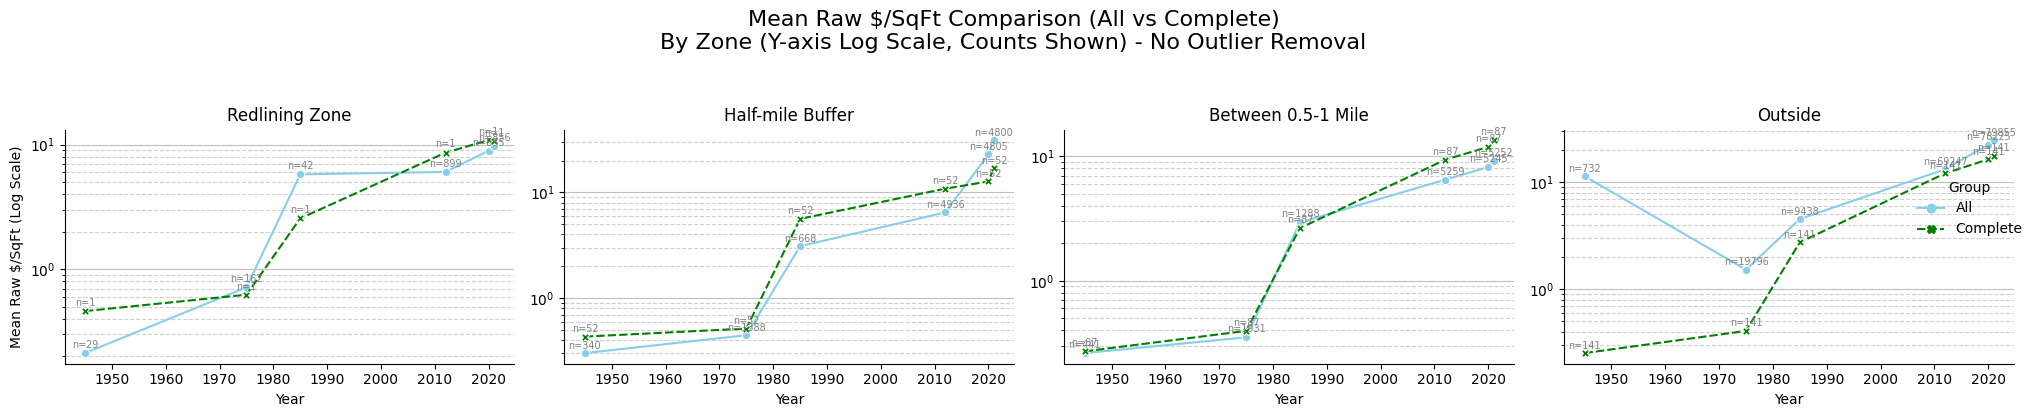

Saved Zone comparison plot to: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/Visualizations/Maps/MEAN_comparison_ZONE_F2025.png


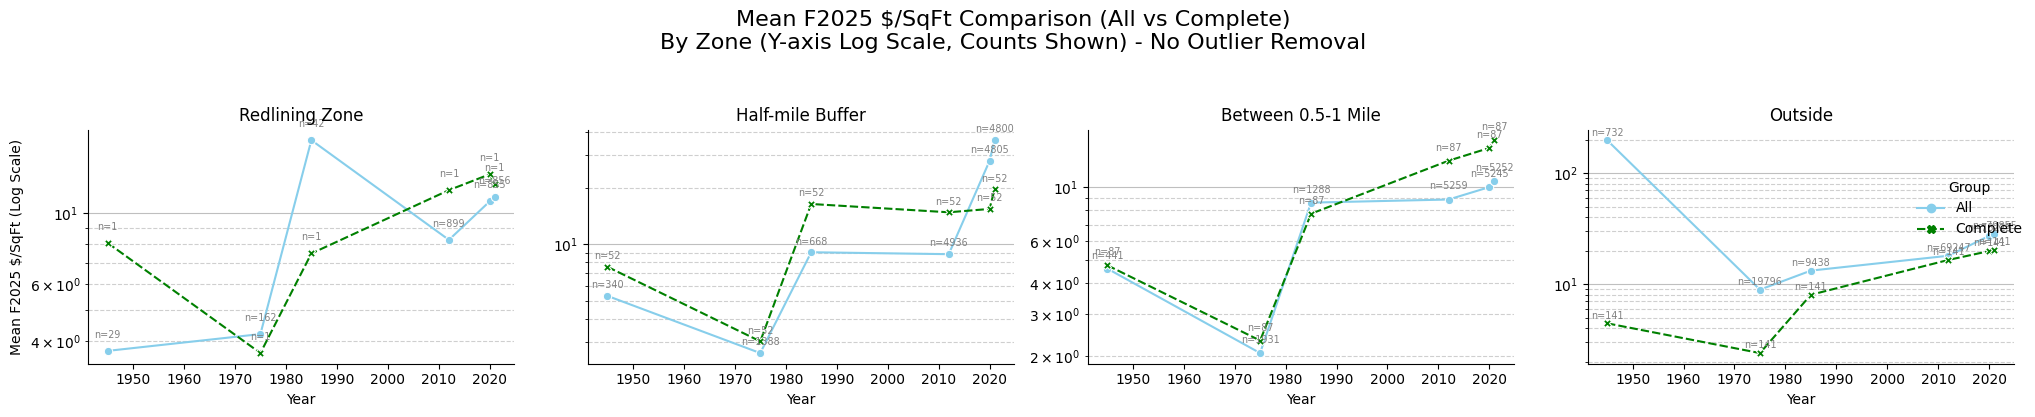


--- Zone Comparison Plotting Complete ---


In [ ]:
# Cell 13: Plot Mean Value Comparison by Zone

print("\n--- Generating Mean Comparison Plots by Zone (Log Scale) ---")

# Define plot function to avoid repetition
def create_faceted_point_plot(data, value_col_label, title_suffix, filename_suffix):
    # Filter out Complete group data if count is very low (e.g., <=1) for stability in plots? Optional.
    # data = data[~((data['Group'] == 'Complete') & (data['Count'] <= 1))]

    if data.empty:
        print(f"No data to plot for {title_suffix}.")
        return

    g = sns.relplot(
        data=data,
        x="Year",
        y="Mean",
        hue="Group",
        col="SubCategory",
        kind="line", # Line connecting points clearly shows trend
        style="Group", # Different line styles or just markers
        markers=True, # Show markers at each year
        col_wrap=4, # Wrap facets into rows
        height=4, aspect=1.2,
        palette={"All": "skyblue", "Complete": "green"},
        legend="full",
        facet_kws={'sharey': False} # Important because log ranges differ
    )

    # Set Y-axis to log scale and add annotations
    for i, ax in enumerate(g.axes.flat):
        ax.set_yscale('log')
        ax.grid(True, which='minor', axis='y', linestyle='--', alpha=0.6)
        ax.grid(True, which='major', axis='y', linestyle='-', alpha=0.8)
        ax.set_title(ax.get_title().replace("SubCategory = ", "")) # Clean facet title

        # Get the data subset for this specific facet (ax)
        # Need the category value corresponding to this ax
        col_var = g.col_names[i] # Get the zone name for this subplot
        facet_data = data[data['SubCategory'] == col_var]

        # Add text annotations for counts
        for idx, row in facet_data.iterrows():
            # Adjust text position slightly to avoid overlapping points/lines
            vertical_offset = row['Mean'] * 0.1 # Small offset relative to value
            ax.text(row['Year'], row['Mean'] + vertical_offset, f"n={int(row['Count'])}",
                    horizontalalignment='center', size='x-small', color='gray') # Make count gray and small


    g.fig.suptitle(f'Mean {value_col_label} Comparison (All vs Complete)\nBy Zone (Y-axis Log Scale, Counts Shown) - No Outlier Removal',
                   y=1.03, fontsize=16) # Adjust y for spacing
    g.set_axis_labels("Year", f"Mean {value_col_label} (Log Scale)")
    g.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout to prevent title overlap

    # Define output path (ensure output_map_dir exists from Cell 2)
    plot_filename = f"MEAN_comparison_ZONE_{filename_suffix}.png"
    plot_output_path = os.path.join(output_map_dir, plot_filename)
    plt.savefig(plot_output_path, dpi=150, bbox_inches='tight')
    print(f"Saved Zone comparison plot to: {plot_output_path}")
    plt.show()


# --- Plot for Raw $/SqFt ---
data_raw_zone = plot_data_zone[plot_data_zone['Metric_Type'] == 'Raw $/SqFt']
create_faceted_point_plot(data_raw_zone, 'Raw $/SqFt', 'by Zone (Raw)', 'RAW')

# --- Plot for F2025 $/SqFt ---
data_f2025_zone = plot_data_zone[plot_data_zone['Metric_Type'] == 'F2025 $/SqFt']
create_faceted_point_plot(data_f2025_zone, 'F2025 $/SqFt', 'by Zone (F2025)', 'F2025')


print("\n--- Zone Comparison Plotting Complete ---")


--- Generating Mean Comparison Plots for ALL Districts (Log Scale) ---
Note: Districts 4, 5, and 6 will likely only show data for the 'All' group.

Generating Raw $/SqFt plot by District...
Saved Zone comparison plot to: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/Visualizations/Maps/MEAN_comparison_ZONE_RAW_ALL_DISTRICTS.png


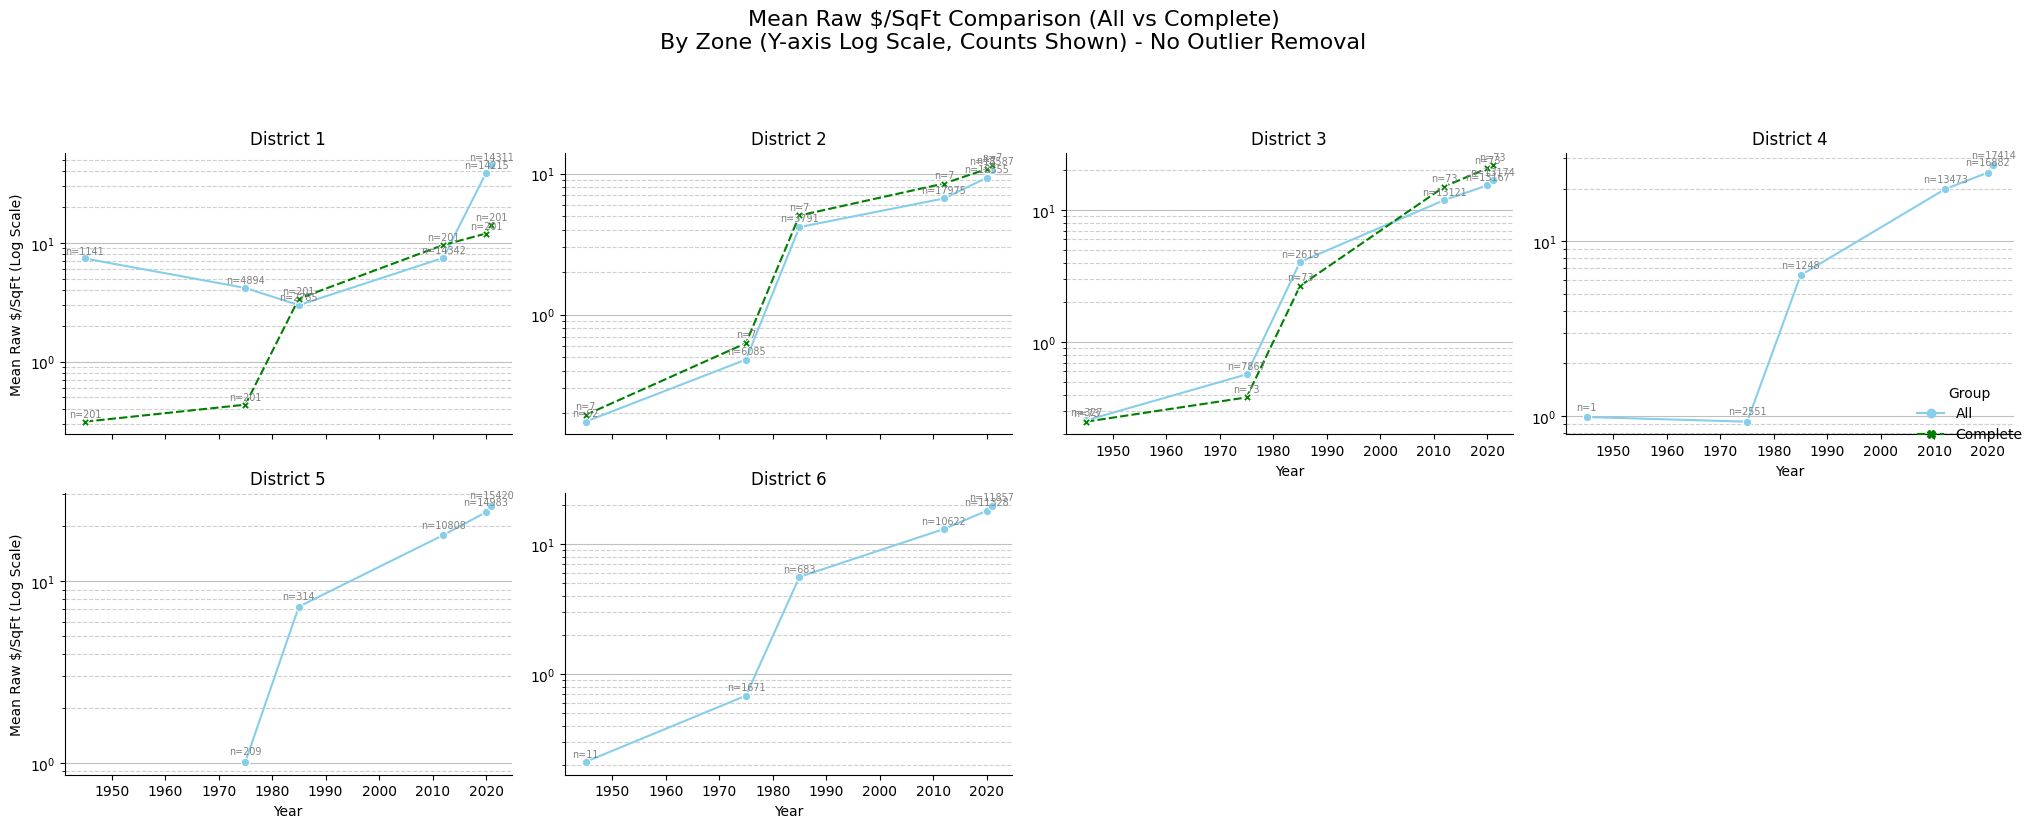


Generating F2025 $/SqFt plot by District...
Saved Zone comparison plot to: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/Visualizations/Maps/MEAN_comparison_ZONE_F2025_ALL_DISTRICTS.png


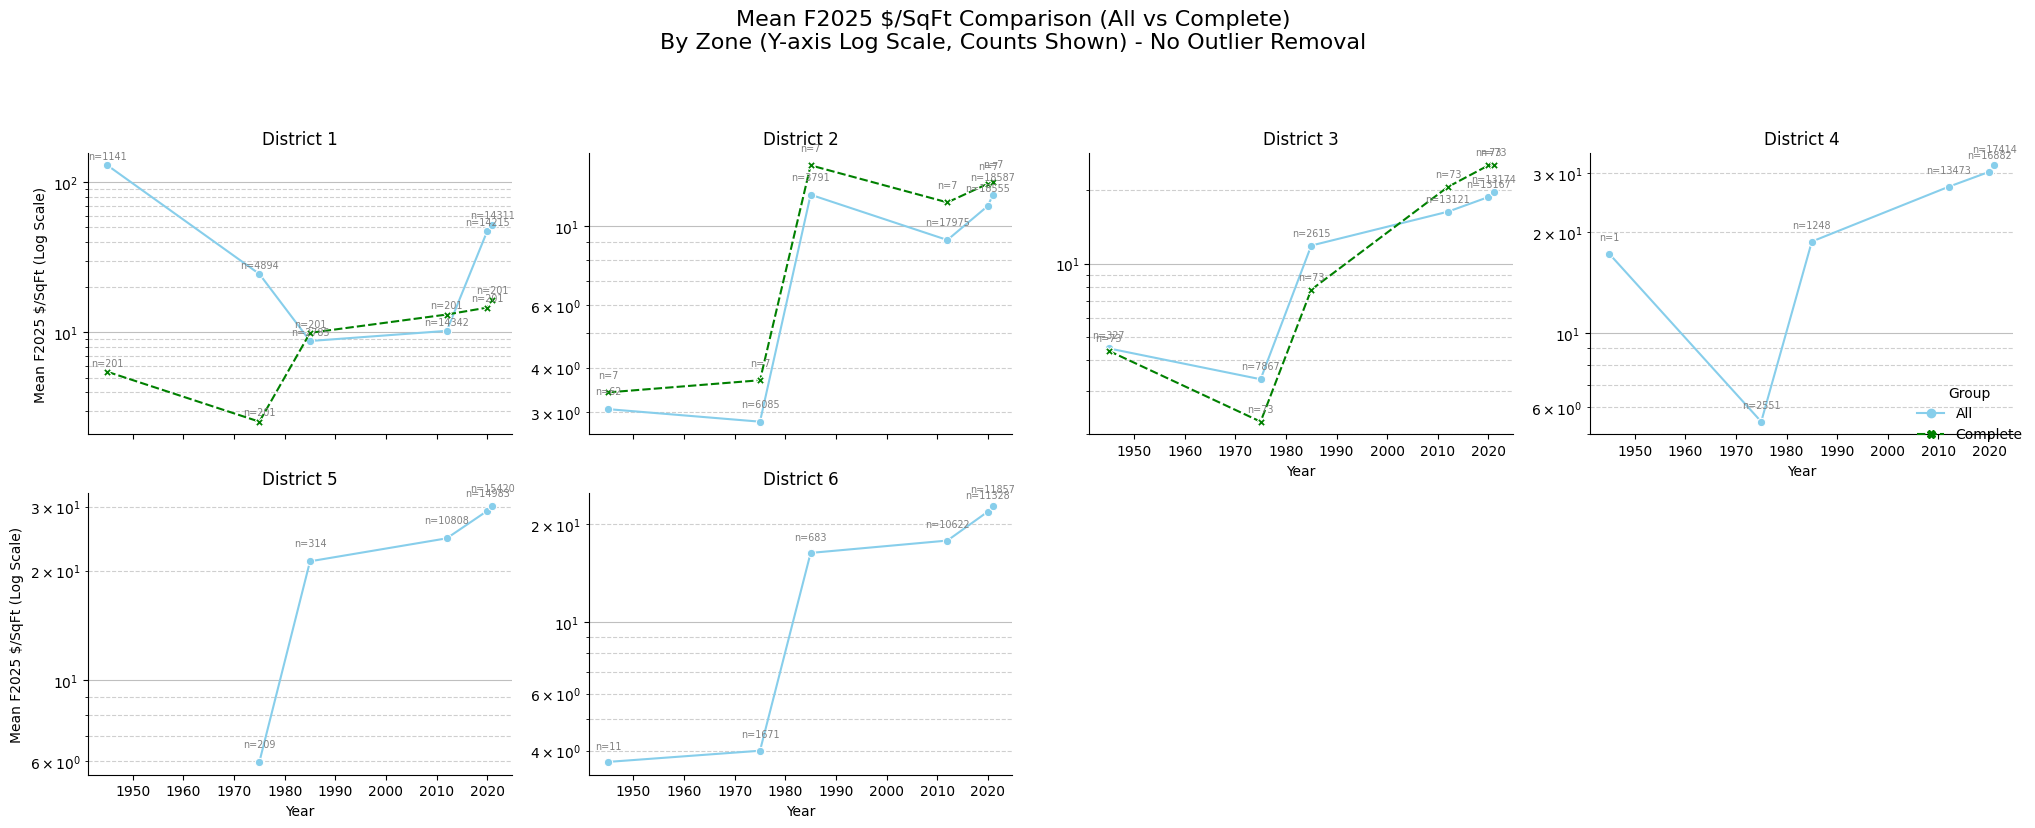


--- All District Comparison Plotting Complete ---


In [ ]:
# Cell 14: Plot Mean Value Comparison by District (Showing All Districts)

print("\n--- Generating Mean Comparison Plots for ALL Districts (Log Scale) ---")
print("Note: Districts 4, 5, and 6 will likely only show data for the 'All' group.")

# Ensure the plotting function from Cell 13 is available
if 'create_faceted_point_plot' not in locals():
     print("ERROR: Plotting function 'create_faceted_point_plot' not found. Please run Cell 13 first.")
     # You might need to copy the function definition here if running standalone
     exit()

# --- Plot for Raw $/SqFt ---
# Use the unfiltered district data prepared in Cell 12
data_raw_district = plot_data_district[plot_data_district['Metric_Type'] == 'Raw $/SqFt']
if not data_raw_district.empty:
    print("\nGenerating Raw $/SqFt plot by District...")
    # Pass the full district data to the plotting function
    create_faceted_point_plot(data_raw_district, 'Raw $/SqFt', 'by ALL Districts (Raw)', 'RAW_ALL_DISTRICTS')
else:
    print("No data available for Raw $/SqFt by District plot.")

# --- Plot for F2025 $/SqFt ---
# Use the unfiltered district data prepared in Cell 12
data_f2025_district = plot_data_district[plot_data_district['Metric_Type'] == 'F2025 $/SqFt']
if not data_f2025_district.empty:
    print("\nGenerating F2025 $/SqFt plot by District...")
    # Pass the full district data to the plotting function
    create_faceted_point_plot(data_f2025_district, 'F2025 $/SqFt', 'by ALL Districts (F2025)', 'F2025_ALL_DISTRICTS')
else:
    print("No data available for F2025 $/SqFt by District plot.")


print("\n--- All District Comparison Plotting Complete ---")

In [ ]:
# Calculate and Display Count Matrix by Zone Category and Year
# Assume gdf_properties_lubbock exists and has ZoneCategory
if 'gdf_properties_lubbock' not in locals() or 'ZoneCategory' not in gdf_properties_lubbock.columns:
    print("ERROR: Required GeoDataFrame 'gdf_properties_lubbock' with 'ZoneCategory' not found.")
    exit() # Or handle error appropriately

print("--- Generating Count Matrix: Valid TotalValuePerSqFT by Zone and Year ---")

all_years = ['1945', '1975', '1985', '2012', '2020', '2021']
zone_results = {} # To store series of counts per year

for year in all_years:
    per_sqft_col = f'TotalValuePerSqFT_{year}'
    if per_sqft_col in gdf_properties_lubbock.columns:
        # Filter for non-missing PerSqFt values for this year within Lubbock properties
        valid_data_this_year = gdf_properties_lubbock[gdf_properties_lubbock[per_sqft_col].notna()]
        # Group by ZoneCategory and count
        zone_counts = valid_data_this_year.groupby('ZoneCategory').size()
        zone_results[year] = zone_counts
    else:
        print(f"Warning: Column {per_sqft_col} not found. Counts for {year} will be zero.")
        zone_results[year] = pd.Series(dtype=int) # Empty series if column missing

# Combine the yearly counts into a DataFrame
zone_matrix = pd.concat(zone_results, axis=1).fillna(0).astype(int)
zone_matrix.columns = all_years # Ensure column names are years

# Calculate Totals
zone_matrix['Total (All Years)'] = zone_matrix.sum(axis=1) # Sum across years for each zone
zone_matrix.loc['Total (All Zones)'] = zone_matrix.sum(axis=0) # Sum down columns for each year + Grand Total

# --- Verification ---
print("\nVerification:")
# Verify Row Totals Sum = Grand Total
row_totals_sum = zone_matrix['Total (All Years)'].drop('Total (All Zones)').sum()
# Verify Col Totals Sum = Grand Total
col_totals_sum = zone_matrix.loc['Total (All Zones)'].drop('Total (All Years)').sum()
grand_total = zone_matrix.loc['Total (All Zones)', 'Total (All Years)']

print(f"  Sum of 'Total (All Years)' column (excluding Grand Total): {row_totals_sum}")
print(f"  Sum of 'Total (All Zones)' row (excluding Grand Total): {col_totals_sum}")
print(f"  Grand Total element: {grand_total}")
if row_totals_sum == grand_total and col_totals_sum == grand_total:
    print("  Verification: Row and Column totals match Grand Total.")
else:
    print("  Verification WARNING: Row and/or Column totals DO NOT match Grand Total!")

# Display the final matrix
print("\n--- Count Matrix by Zone ---")
# Format for printing
pd.options.display.float_format = '{:,.0f}'.format
print(zone_matrix.to_markdown())
pd.reset_option('display.float_format')
print("-----------------------------")

--- Generating Count Matrix: Valid TotalValuePerSqFT by Zone and Year ---

Verification:
  Sum of 'Total (All Years)' column (excluding Grand Total): 296489
  Sum of 'Total (All Zones)' row (excluding Grand Total): 296489
  Grand Total element: 296489
  Verification: Row and Column totals match Grand Total.

--- Count Matrix by Zone ---
| ZoneCategory       |   1945 |   1975 |   1985 |   2012 |   2020 |   2021 |   Total (All Years) |
|:-------------------|-------:|-------:|-------:|-------:|-------:|-------:|--------------------:|
| Between 0.5-1 Mile |    441 |   1931 |   1288 |   5259 |   5245 |   5252 |               19416 |
| Half-mile Buffer   |    340 |   1388 |    668 |   4936 |   4805 |   4800 |               16937 |
| Outside            |    732 |  19796 |   9438 |  69247 |  78225 |  79855 |              257293 |
| Redlining Zone     |     29 |    162 |     42 |    899 |    855 |    856 |                2843 |
| Total (All Zones)  |   1542 |  23277 |  11436 |  80341 |  89130 |

In [ ]:
# Calculate and Display Count Matrix by Council District and Year
# Assume gdf_properties_lubbock exists and has IsInCouncilDistrict
if 'gdf_properties_lubbock' not in locals() or 'IsInCouncilDistrict' not in gdf_properties_lubbock.columns:
    print("ERROR: Required GeoDataFrame 'gdf_properties_lubbock' with 'IsInCouncilDistrict' not found.")
    exit() # Or handle error appropriately

print("\n--- Generating Count Matrix: Valid TotalValuePerSqFT by District and Year ---")

all_years = ['1945', '1975', '1985', '2012', '2020', '2021']
district_results = {} # To store series of counts per year

for year in all_years:
    per_sqft_col = f'TotalValuePerSqFT_{year}'
    if per_sqft_col in gdf_properties_lubbock.columns:
        # Filter for non-missing PerSqFt values for this year within Lubbock properties
        valid_data_this_year = gdf_properties_lubbock[gdf_properties_lubbock[per_sqft_col].notna()]
        # Group by District and count
        district_counts = valid_data_this_year.groupby('IsInCouncilDistrict').size()
        district_results[year] = district_counts
    else:
        print(f"Warning: Column {per_sqft_col} not found. Counts for {year} will be zero.")
        district_results[year] = pd.Series(dtype=int) # Empty series if column missing

# Combine the yearly counts into a DataFrame
district_matrix = pd.concat(district_results, axis=1).fillna(0).astype(int)
district_matrix.columns = all_years # Ensure column names are years
district_matrix.index.name = 'District' # Name the index

# Calculate Totals
district_matrix['Total (All Years)'] = district_matrix.sum(axis=1) # Sum across years for each district
district_matrix.loc['Total (All Districts)'] = district_matrix.sum(axis=0) # Sum down columns for each year + Grand Total

# --- Verification ---
print("\nVerification:")
# Verify Row Totals Sum = Grand Total
row_totals_sum_dist = district_matrix['Total (All Years)'].drop('Total (All Districts)').sum()
# Verify Col Totals Sum = Grand Total
col_totals_sum_dist = district_matrix.loc['Total (All Districts)'].drop('Total (All Years)').sum()
grand_total_dist = district_matrix.loc['Total (All Districts)', 'Total (All Years)']

print(f"  Sum of 'Total (All Years)' column (excluding Grand Total): {row_totals_sum_dist}")
print(f"  Sum of 'Total (All Districts)' row (excluding Grand Total): {col_totals_sum_dist}")
print(f"  Grand Total element: {grand_total_dist}")
if row_totals_sum_dist == grand_total_dist and col_totals_sum_dist == grand_total_dist:
    print("  Verification: Row and Column totals match Grand Total.")
else:
    print("  Verification WARNING: Row and/or Column totals DO NOT match Grand Total!")

# Display the final matrix
print("\n--- Count Matrix by District ---")
# Format for printing
pd.options.display.float_format = '{:,.0f}'.format
print(district_matrix.to_markdown())
pd.reset_option('display.float_format')
print("--------------------------------")


--- Generating Count Matrix: Valid TotalValuePerSqFT by District and Year ---

Verification:
  Sum of 'Total (All Years)' column (excluding Grand Total): 296489
  Sum of 'Total (All Districts)' row (excluding Grand Total): 296489
  Grand Total element: 296489
  Verification: Row and Column totals match Grand Total.

--- Count Matrix by District ---
| District              |   1945 |   1975 |   1985 |   2012 |   2020 |   2021 |   Total (All Years) |
|:----------------------|-------:|-------:|-------:|-------:|-------:|-------:|--------------------:|
| 1                     |   1141 |   4894 |   2785 |  14342 |  14215 |  14311 |               51688 |
| 2                     |     62 |   6085 |   3791 |  17975 |  18555 |  18587 |               65055 |
| 3                     |    327 |   7867 |   2615 |  13121 |  13167 |  13174 |               50271 |
| 4                     |      1 |   2551 |   1248 |  13473 |  16882 |  17414 |               51569 |
| 6                     |     11 |  

In [ ]:
# Define Output Base Path and Create Directory Structure
# --- Define Output Path ---
output_base_path = "/content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/Visualizations/281 (Complete Present in all the years) vs All"

# Statistics and Stratifications to loop through
stats_to_plot = ['Mean', 'Median', 'Mode', 'Min', 'Max', 'Q1', 'Q3']
stratifications = ['By Zone', 'By District']

print(f"--- Creating Output Directory Structure under: {output_base_path} ---")

# Create base path if it doesn't exist
os.makedirs(output_base_path, exist_ok=True)

# Create subdirectories
for stat in stats_to_plot:
    for strat in stratifications:
        # Path example: .../Visualizations/281...vs All/Mean/By Zone/
        folder_path = os.path.join(output_base_path, stat, strat.replace(" ", "_")) # Use underscore for folder name
        os.makedirs(folder_path, exist_ok=True)
        print(f"Ensured directory exists: {folder_path}")

print("--- Directory Structure Ready ---")

--- Creating Output Directory Structure under: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/Visualizations/281 (Complete Present in all the years) vs All ---
Ensured directory exists: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/Visualizations/281 (Complete Present in all the years) vs All/Mean/By_Zone
Ensured directory exists: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/Visualizations/281 (Complete Present in all the years) vs All/Mean/By_District
Ensured directory exists: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/Visualizations/281 (Complete Present in all the years) vs All/Median/By_Zone
Ensured directory exists: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/Visualizations/281 (Complete Present in all the years) vs All/Median/By_District
Ensured directory exists: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan

In [ ]:
# Cell 13: Enhanced Plotting Function (REVISED Parameter Name)
import traceback # Import traceback for detailed error printing

# Assume plot_data_zone and plot_data_district exist from previous calculation
if 'plot_data_zone' not in locals() or 'plot_data_district' not in locals():
     print("ERROR: plot_data_zone or plot_data_district DataFrames not found. Please run Cell 12 first.")
     exit()

# *** Function Definition with CORRECTED parameter name ***
def create_comparison_plot(data, statistic, stratification_level, metric_type, y_scale, output_path):
    """
    Generates and saves a faceted line/point plot comparing 'All' vs 'Complete'.

    Args:
        data (pd.DataFrame): DataFrame filtered for the specific stratification & metric type.
        statistic (str): The statistic column name ('Mean', 'Median', etc.).
        stratification_level (str): 'By Zone' or 'By District'. <--- CHANGED NAME HERE
        metric_type (str): 'Raw $/SqFt' or 'F2025 $/SqFt'.
        y_scale (str): 'log' or 'linear'.
        output_path (str): Full path to save the PNG file.
    """
    title_stat = statistic
    print(f"  Generating plot: {title_stat} - {stratification_level} - {metric_type} ({y_scale} scale)")

    if data.empty:
        print(f"    Skipping plot - No data provided for this combination.")
        return

    # Determine plotting parameters based on stratification level
    col_var = "SubCategory"
    col_order = None
    cat_order = None
    # Use stratification_level here
    if stratification_level == 'By Zone':
        col_wrap = 2; height = 4.5; aspect_ratio = 1.3; subcategory_title = "Zone"
        cat_order = ['Redlining Zone', 'Half-mile Buffer', 'Between 0.5-1 Mile', 'Outside']
        data_subset = data[data['SubCategory'].isin(cat_order)].copy()
        if data_subset.empty :
             print(f"    Warning: No data remains for standard zones after filtering for {statistic}, {metric_type}")
             return
        available_cats = [cat for cat in cat_order if cat in data_subset['SubCategory'].unique()]
        if not available_cats:
             print(f"    Warning: No standard zones found in data for {statistic}, {metric_type}")
             return
        col_order = available_cats
    # Use stratification_level here
    elif stratification_level == 'By District':
        col_wrap = 3; height = 4; aspect_ratio = 1.2; subcategory_title = "District"
        try:
            unique_districts = sorted([int(d.split(' ')[-1]) for d in data['SubCategory'].unique()])
            col_order = [f"District {d}" for d in unique_districts]
        except:
             col_order = sorted(data['SubCategory'].unique())
        data_subset = data # Use the full data passed for districts

    else:
        print(f"    Skipping plot - Unknown stratification level: {stratification_level}")
        return

    # Handle zero/negative values for log scale IN a copy for plotting
    plot_data_viz = data_subset.copy() # Use the filtered/full data subset determined above
    plot_data_viz[statistic] = pd.to_numeric(plot_data_viz[statistic], errors='coerce') # Ensure numeric
    if y_scale == 'log':
        invalid_values_mask = plot_data_viz[statistic] <= 0
        num_invalid = invalid_values_mask.sum()
        if num_invalid > 0:
            print(f"    Note: Found {num_invalid} non-positive '{statistic}' values. Replacing with NaN for log plot.")
            plot_data_viz.loc[invalid_values_mask, statistic] = np.nan

    plot_data_viz.dropna(subset=[statistic], inplace=True)
    if plot_data_viz.empty:
        print(f"    Skipping plot - No valid data points remain for {statistic} after cleaning/NaN removal for {y_scale} scale.")
        return

    plot_data_viz['Year'] = pd.to_numeric(plot_data_viz['Year']) # Ensure Year is numeric for axis

    # --- Create the plot ---
    try:
        sns.set_theme(style="whitegrid")
        g = sns.relplot(
            data=plot_data_viz,
            x="Year", y=statistic,
            hue="Group", col=col_var, kind="line", style="Group",
            markers=True, col_wrap=col_wrap, col_order=col_order,
            height=height, aspect=aspect_ratio,
            palette={"All": "skyblue", "Complete": "green"},
            legend="full", facet_kws={'sharey': False}
        )

        # --- Customizations (Scale, Grid, Titles, Annotations) ---
        all_axes = list(g.axes.flat)
        plotted_cats_actual = [col for col in col_order if col in plot_data_viz[col_var].unique()] if col_order else sorted(plot_data_viz[col_var].unique())

        for i, ax in enumerate(all_axes):
             if i >= len(plotted_cats_actual): ax.set_visible(False); continue

             current_cat = plotted_cats_actual[i]
             ax.set_yscale(y_scale)
             ax.grid(True, which='major', axis='y', linestyle='-', alpha=0.8)
             if y_scale == 'log': ax.grid(True, which='minor', axis='y', linestyle='--', alpha=0.6)

             ax.set_title(f"{current_cat}")

             # --- Add text annotations for counts ---
             facet_data_orig_count = data_subset[data_subset[col_var] == current_cat]
             viz_data_lookup = plot_data_viz[plot_data_viz[col_var]==current_cat][['Year','Group', statistic]].copy()

             for _, row in facet_data_orig_count.iterrows():
                 lookup = viz_data_lookup[(viz_data_lookup['Year'] == row['Year']) & (viz_data_lookup['Group'] == row['Group'])]
                 if not lookup.empty and pd.notna(lookup[statistic].iloc[0]):
                      y_pos = lookup[statistic].iloc[0]
                      y_min, y_max = ax.get_ylim() # Get axis limits *after* setting scale
                      if y_scale == 'log':
                           if y_max <= y_min or y_max <=0 or y_min <=0 or y_pos <=0 : log_offset_mult = 1.2 # Fallback
                           else:
                                log_range = np.log10(y_max) - np.log10(y_min); log_offset = log_range * 0.05
                                log_offset_mult = np.power(10, log_offset)
                           text_y = y_pos * log_offset_mult if row['Group'] == 'All' else y_pos / log_offset_mult
                           if text_y <= 0: text_y = y_pos * 1.1; # Adjustments to keep within bounds
                           if y_min > 0 and text_y < y_min: text_y = y_min * (log_offset_mult if log_offset_mult > 1 else 1.1)
                           if y_max > 0 and text_y > y_max: text_y = y_max / (log_offset_mult if log_offset_mult > 1 else 1.1)

                      else: # Linear scale
                           offset = (y_max - y_min) * 0.03
                           text_y = y_pos + offset if row['Group'] == 'All' else y_pos - offset
                           if text_y < y_min: text_y = y_min + offset*0.5
                           if text_y > y_max: text_y = y_max - offset*0.5

                      ax.text(row['Year'], text_y, f"n={int(row['Count']):,d}", # Format count
                              horizontalalignment='center', verticalalignment='center',
                              size=5.5, color='dimgray', weight='light',
                              bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=0.6, ec='none'))

        # --- Final Figure Adjustments and Save ---
        plt.subplots_adjust(hspace=0.4, wspace=0.3)
        g.fig.suptitle(f'{title_stat} Comparison (All vs Complete)\n{stratification_level.replace("By ", "by ")} ({metric_type}, Y-axis: {y_scale.capitalize()}) - Counts Shown',
                       y=1.05, fontsize=14)
        g.set_axis_labels("Year", f"{title_stat} ($/SqFt, {y_scale.capitalize()} Scale)")
        g.tight_layout(rect=[0, 0, 1, 0.98])

        plt.savefig(output_path, dpi=200, bbox_inches='tight')
        print(f"    Plot saved to: {os.path.basename(output_path)}")
        plt.close(g.fig)

    except Exception as e:
        print(f"    !!!!! ERROR generating plot for {title_stat} - {stratification_level} - {metric_type} !!!!!")
        print(f"    Error Message: {e}")
        traceback.print_exc() # Print full traceback
        if 'g' in locals() and hasattr(g, 'fig'): plt.close(g.fig)


print("\n--- Plotting Function Defined (Corrected Parameter Name) ---")


--- Plotting Function Defined (Corrected Parameter Name) ---


In [ ]:
# Cell 15: Loop Through All Combinations and Generate Plots (DEBUGGED Filtering)

# --- Ensure necessary DataFrames exist ---
if 'stats_summary_df' not in locals(): print("ERROR: 'stats_summary_df' not found."); exit()
if 'plot_data_zone' not in locals(): print("ERROR: 'plot_data_zone' not found."); exit()
if 'plot_data_district' not in locals(): print("ERROR: 'plot_data_district' not found."); exit()
if 'create_comparison_plot' not in locals(): print("ERROR: 'create_comparison_plot' function not found."); exit()


print("\n--- Starting Plot Generation Loop (DEBUGGED Filtering) ---")

# Statistics to plot and their preferred y-axis scale
stats_and_scales = {
    'Mean': 'log', 'Median': 'log', 'Mode': 'linear',
    'Min': 'linear', 'Max': 'log', 'Q1': 'log', 'Q3': 'log'
}
stratification_map = {'By Zone': plot_data_zone, 'By District': plot_data_district}
metric_types = ['Raw $/SqFt', 'F2025 $/SqFt'] # Use these for labels and branching logic

plot_count = 0
error_count = 0

# Nested loops for all combinations
for statistic, y_scale in stats_and_scales.items():
    print(f"\nProcessing Statistic: {statistic} (Scale: {y_scale})")

    # Check if the statistic COLUMN exists in the base summary DF
    if statistic not in stats_summary_df.columns:
        print(f"  WARNING: Statistic column '{statistic}' not found in 'stats_summary_df'. Skipping plots for this statistic.")
        error_count += len(stratification_map) * len(metric_types)
        continue # Go to next statistic

    for strat_level, source_data in stratification_map.items():
        print(f"  Processing Level: {strat_level}")

        # --- CRITICAL CHECK: Verify columns in source_data ---
        if source_data.empty:
             print(f"    Skipping level '{strat_level}' - Input source_data is empty.")
             continue
        if 'Metric' not in source_data.columns:
            print(f"    ERROR: Column 'Metric' is MISSING in the '{strat_level}' DataFrame slice ('source_data'). Check Cell 12.")
            error_count += len(metric_types)
            continue # Skip this stratification level for this statistic
        if statistic not in source_data.columns:
             print(f"    ERROR: Statistic column '{statistic}' is MISSING in the '{strat_level}' DataFrame slice ('source_data'). Check Cell 12.")
             error_count += len(metric_types)
             continue # Skip this stratification level for this statistic
        # --- End Critical Check ---


        for metric_label in metric_types:
            print(f"    Processing Metric Type: {metric_label}")

            # --- Filter data for the current metric type ---
            if metric_label == 'Raw $/SqFt':
                filter_condition = ~source_data['Metric'].astype(str).str.contains('F2025', na=False)
                file_suffix = 'RAW'
            elif metric_label == 'F2025 $/SqFt':
                filter_condition = source_data['Metric'].astype(str).str.contains('F2025', na=False)
                file_suffix = 'F2025'
            else:
                 print(f"      Skipping unknown metric type: {metric_label}")
                 continue

            data_to_plot = source_data[filter_condition].copy()
            data_to_plot['Metric_Type'] = metric_label # Assign consistent label
            # --- End Filtering ---

            if data_to_plot.empty:
                 print(f"      No data found for {statistic} - {strat_level} - {metric_label}. Skipping plot.")
                 continue

            # Define output path and filename
            stat_folder = statistic
            strat_folder_name = strat_level.replace(" ", "_")
            filename = f"{statistic}_{strat_folder_name}_{file_suffix}.png"
            full_output_path = os.path.join(output_base_path, stat_folder, strat_folder_name, filename)

            # Call the plotting function
            try:
                create_comparison_plot(
                    data=data_to_plot,
                    statistic=statistic,
                    stratification_level=strat_level,
                    metric_type=metric_label,
                    y_scale=y_scale,
                    output_path=full_output_path
                )
                plot_count += 1
            except Exception as e:
                 print(f"!!! FAILED to generate plot: {filename} !!!")
                 import traceback
                 traceback.print_exc() # Print full traceback for errors during plotting
                 error_count += 1

            # Periodically close figures to conserve memory
            if plot_count > 0 and plot_count % 4 == 0: plt.close('all')

# Final cleanup
plt.close('all')

print(f"\n--- Plot Generation Loop Complete ---")
print(f"Finished processing all statistics and stratifications.")
print(f"Successfully generated {plot_count} plots.")
if error_count > 0:
    print(f"Encountered {error_count} errors during plot generation.")


--- Starting Plot Generation Loop (DEBUGGED Filtering) ---

Processing Statistic: Mean (Scale: log)
  Processing Level: By Zone
    Processing Metric Type: Raw $/SqFt
  Generating plot: Mean - By Zone - Raw $/SqFt (log scale)
    Plot saved to: Mean_By_Zone_RAW.png
    Processing Metric Type: F2025 $/SqFt
  Generating plot: Mean - By Zone - F2025 $/SqFt (log scale)
    Plot saved to: Mean_By_Zone_F2025.png
  Processing Level: By District
    Processing Metric Type: Raw $/SqFt
  Generating plot: Mean - By District - Raw $/SqFt (log scale)
    Plot saved to: Mean_By_District_RAW.png
    Processing Metric Type: F2025 $/SqFt
  Generating plot: Mean - By District - F2025 $/SqFt (log scale)
    Plot saved to: Mean_By_District_F2025.png

Processing Statistic: Median (Scale: log)
  Processing Level: By Zone
    Processing Metric Type: Raw $/SqFt
  Generating plot: Median - By Zone - Raw $/SqFt (log scale)
    Plot saved to: Median_By_Zone_RAW.png
    Processing Metric Type: F2025 $/SqFt
  Gen

In [ ]:
!pip install dataframe_image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.7/385.7 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 MB 18.7 MB/s eta 0:00:00


In [ ]:
# Cell: Save Count Matrices as Images
# Attempt to import dataframe_image, provide instructions if missing
try:
    import dataframe_image as dfi
    exporter_available = True
except ImportError:
    print("INFO: 'dataframe_image' library not found. Cannot export tables as images.")
    print("      To install, run: !pip install dataframe_image")
    exporter_available = False

# --- Assume zone_matrix and district_matrix exist from previous cells ---
if 'zone_matrix' not in locals() or not isinstance(zone_matrix, pd.DataFrame):
    print("ERROR: DataFrame 'zone_matrix' not found or is not a DataFrame.")
    print("       Please ensure Cell 15 (or equivalent) ran successfully.")
    exporter_available = False # Can't export if data is missing

if 'district_matrix' not in locals() or not isinstance(district_matrix, pd.DataFrame):
    print("ERROR: DataFrame 'district_matrix' not found or is not a DataFrame.")
    print("       Please ensure Cell 16 (or equivalent) ran successfully.")
    exporter_available = False # Can't export if data is missing


# --- Define Output Directory for Images ---
# Use the main visualization path defined earlier, create a subfolder
output_base_path = "/content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/Visualizations/281 (Complete Present in all the years) vs All"
image_output_dir = os.path.join(output_base_path, "Count_Matrices")
os.makedirs(image_output_dir, exist_ok=True)
print(f"\nSaving count matrix images to: {image_output_dir}")

# --- Export Zone Matrix Image ---
if exporter_available and 'zone_matrix' in locals():
    zone_image_path = os.path.join(image_output_dir, "Count_Matrix_Zone_vs_Year.png")
    try:
        print(f"  Exporting Zone Matrix to {zone_image_path}...")
        # Make a copy for formatting to avoid changing original df
        zone_matrix_formatted = zone_matrix.copy()
        # Apply comma formatting to all integer columns/cells
        zone_matrix_formatted = zone_matrix_formatted.map(lambda x: f"{x:,.0f}" if isinstance(x, (int, float)) and pd.notna(x) else x)

        dfi.export(
            zone_matrix_formatted, # Use the formatted DataFrame
            zone_image_path,
            # Table styling options (optional)
            table_conversion='matplotlib', # Use matplotlib backend for potentially better rendering
            fontsize=10,
            max_rows=-1 # Export all rows
            )
        print("    Zone Matrix image saved.")
    except Exception as e:
        print(f"    ERROR exporting Zone Matrix image: {e}")

# --- Export District Matrix Image ---
if exporter_available and 'district_matrix' in locals():
    district_image_path = os.path.join(image_output_dir, "Count_Matrix_District_vs_Year.png")
    try:
        print(f"  Exporting District Matrix to {district_image_path}...")
        # Make a copy for formatting
        district_matrix_formatted = district_matrix.copy()
        # Apply comma formatting
        district_matrix_formatted = district_matrix_formatted.map(lambda x: f"{x:,.0f}" if isinstance(x, (int, float)) and pd.notna(x) else x)

        dfi.export(
             district_matrix_formatted, # Use the formatted DataFrame
             district_image_path,
             table_conversion='matplotlib',
             fontsize=10,
             max_rows=-1
             )
        print("    District Matrix image saved.")
    except Exception as e:
        print(f"    ERROR exporting District Matrix image: {e}")


if not exporter_available:
    print("\nSkipped image export because 'dataframe_image' library is not available.")

print("\n--- Matrix Image Export Process Complete ---")


Saving count matrix images to: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/Visualizations/281 (Complete Present in all the years) vs All/Count_Matrices
  Exporting Zone Matrix to /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/Visualizations/281 (Complete Present in all the years) vs All/Count_Matrices/Count_Matrix_Zone_vs_Year.png...
    Zone Matrix image saved.
  Exporting District Matrix to /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/Visualizations/281 (Complete Present in all the years) vs All/Count_Matrices/Count_Matrix_District_vs_Year.png...
    District Matrix image saved.

--- Matrix Image Export Process Complete ---


In [3]:
# Create and Save Count Matrices for "Complete" Group
# --- Assume gdf_properties_lubbock exists from previous steps ---
if 'gdf_properties_lubbock' not in locals():
     print("ERROR: GeoDataFrame 'gdf_properties_lubbock' not found. Please run previous cells.")
     exit()
# --- Ensure necessary columns exist ---
required_cols_for_count = ['IsCompleteGroup', 'ZoneCategory', 'IsInCouncilDistrict']
all_years = ['1945', '1975', '1985', '2012', '2020', '2021']
for year in all_years:
    required_cols_for_count.append(f'TotalValuePerSqFT_{year}')

missing_req_cols = [col for col in required_cols_for_count if col not in gdf_properties_lubbock.columns]
if missing_req_cols:
    print(f"ERROR: Missing required columns in gdf_properties_lubbock: {missing_req_cols}")
    exit()

print("--- Generating Count Matrices for the 'Complete' Group Only ---")

# --- Define Output Directory (same as before) ---
output_base_path = "/content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/Visualizations/281 (Complete Present in all the years) vs All"
image_output_dir = os.path.join(output_base_path, "Count_Matrices")
os.makedirs(image_output_dir, exist_ok=True) # Ensure it exists

# 1. Filter for the "Complete" Group
gdf_complete_props = gdf_properties_lubbock[gdf_properties_lubbock['IsCompleteGroup']].copy()
print(f"Analyzing the {len(gdf_complete_props)} properties in the 'Complete' group.")

if gdf_complete_props.empty:
    print("No properties found in the 'Complete' group. Cannot generate matrices.")
else:
    # --- Calculate Matrix by Zone Category ---
    print("\nCalculating Matrix by Zone...")
    zone_results_complete = {}
    for year in all_years:
        per_sqft_col = f'TotalValuePerSqFT_{year}'
        # Filter COMPLETE properties for non-missing PerSqFt values for this year
        valid_data_this_year = gdf_complete_props[gdf_complete_props[per_sqft_col].notna()]
        # Group by ZoneCategory and count
        zone_counts = valid_data_this_year.groupby('ZoneCategory').size()
        zone_results_complete[year] = zone_counts

    zone_matrix_complete = pd.concat(zone_results_complete, axis=1).fillna(0).astype(int)
    zone_matrix_complete.columns = all_years
    zone_matrix_complete['Total (All Years)'] = zone_matrix_complete.sum(axis=1)
    zone_matrix_complete.loc['Total (All Zones)'] = zone_matrix_complete.sum(axis=0)

    # --- Verification ---
    row_totals_sum_z = zone_matrix_complete['Total (All Years)'].drop('Total (All Zones)').sum()
    col_totals_sum_z = zone_matrix_complete.loc['Total (All Zones)'].drop('Total (All Years)').sum()
    grand_total_z = zone_matrix_complete.loc['Total (All Zones)', 'Total (All Years)']
    print("  Zone Matrix Verification:")
    if row_totals_sum_z == grand_total_z and col_totals_sum_z == grand_total_z:
        print("    Row and Column totals match Grand Total.")
    else: print("    WARNING: Row/Column totals DO NOT match Grand Total!")

    # --- Display Zone Matrix ---
    print("\n--- Count Matrix by Zone (Complete Group) ---")
    pd.options.display.float_format = '{:,.0f}'.format
    print(zone_matrix_complete.to_markdown())
    pd.reset_option('display.float_format')
    print("-------------------------------------------")


    # --- Calculate Matrix by Council District ---
    print("\nCalculating Matrix by District...")
    district_results_complete = {}
    for year in all_years:
        per_sqft_col = f'TotalValuePerSqFT_{year}'
        # Filter COMPLETE properties for non-missing PerSqFt values for this year
        valid_data_this_year = gdf_complete_props[gdf_complete_props[per_sqft_col].notna()]
        # Group by District and count
        district_counts = valid_data_this_year.groupby('IsInCouncilDistrict').size()
        district_results_complete[year] = district_counts

    district_matrix_complete = pd.concat(district_results_complete, axis=1).fillna(0).astype(int)
    district_matrix_complete.columns = all_years
    district_matrix_complete.index.name = 'District'
    district_matrix_complete['Total (All Years)'] = district_matrix_complete.sum(axis=1)
    district_matrix_complete.loc['Total (All Districts)'] = district_matrix_complete.sum(axis=0)

    # --- Verification ---
    row_totals_sum_d = district_matrix_complete['Total (All Years)'].drop('Total (All Districts)').sum()
    col_totals_sum_d = district_matrix_complete.loc['Total (All Districts)'].drop('Total (All Years)').sum()
    grand_total_d = district_matrix_complete.loc['Total (All Districts)', 'Total (All Years)']
    print("  District Matrix Verification:")
    if row_totals_sum_d == grand_total_d and col_totals_sum_d == grand_total_d:
        print("    Row and Column totals match Grand Total.")
    else: print("    WARNING: Row/Column totals DO NOT match Grand Total!")

    # --- Display District Matrix ---
    print("\n--- Count Matrix by District (Complete Group) ---")
    pd.options.display.float_format = '{:,.0f}'.format
    print(district_matrix_complete.to_markdown())
    pd.reset_option('display.float_format')
    print("----------------------------------------------")


    # --- Save Matrices as Images ---
    if exporter_available:
        # Zone Matrix Image
        zone_image_path_comp = os.path.join(image_output_dir, "Count_Matrix_Zone_vs_Year_COMPLETE_GROUP.png")
        try:
            print(f"\nExporting COMPLETE Zone Matrix to {zone_image_path_comp}...")
            zone_matrix_formatted = zone_matrix_complete.copy().map(lambda x: f"{x:,.0f}" if isinstance(x, (int, float)) and pd.notna(x) else x)
            dfi.export(zone_matrix_formatted, zone_image_path_comp, table_conversion='matplotlib', fontsize=10, max_rows=-1)
            print("  Complete Zone Matrix image saved.")
        except Exception as e:
            print(f"  ERROR exporting Complete Zone Matrix image: {e}")

        # District Matrix Image
        district_image_path_comp = os.path.join(image_output_dir, "Count_Matrix_District_vs_Year_COMPLETE_GROUP.png")
        try:
            print(f"\nExporting COMPLETE District Matrix to {district_image_path_comp}...")
            district_matrix_formatted = district_matrix_complete.copy().map(lambda x: f"{x:,.0f}" if isinstance(x, (int, float)) and pd.notna(x) else x)
            dfi.export(district_matrix_formatted, district_image_path_comp, table_conversion='matplotlib', fontsize=10, max_rows=-1)
            print("  Complete District Matrix image saved.")
        except Exception as e:
            print(f"  ERROR exporting Complete District Matrix image: {e}")
    else:
        print("\nSkipped image export because 'dataframe_image' library is not available.")

print("\n--- Complete Group Count Matrix Process Complete ---")

ERROR: GeoDataFrame 'gdf_properties_lubbock' not found. Please run previous cells.


NameError: name 'gdf_properties_lubbock' is not defined

In [ ]:
years = ['1945', '1975', '1985', '2012', '2020', '2021']

for year in years:
    df_year = stats_summary_df[stats_summary_df['Year'] == year]
    filename = f"StatsSummary_{year}.csv"
    df_year.to_csv(filename, index=False)
    print(f"Saved: {filename}")


Saved: StatsSummary_1945.csv
Saved: StatsSummary_1975.csv
Saved: StatsSummary_1985.csv
Saved: StatsSummary_2012.csv
Saved: StatsSummary_2020.csv
Saved: StatsSummary_2021.csv
